<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
import os, datetime

from matplotlib import pyplot
pyplot.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<h2>Data Processing</h2>

In [2]:
data_path = '~/data/cd560d6ec65c4e79.csv'

#TODO: get data and read more data
# df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,200000)], nrows=1000000)
df = pd.read_csv(data_path, delimiter=',', usecols=['DATE', 'TIME_M', 'BID', 'BIDSIZ', 'ASK', 'ASKSIZ', 'SYM_ROOT'],skiprows=[i for i in range(1,5000000)], nrows=32000)

# Replace 0 to avoid dividing by 0 later on
# TODO: SHOULD USE FFILL, but doesn't work if first entry is 0
# or IDEALLY, USE SOME METHOD TO INDICATE VOLUME IS 0
df['BID'].replace(to_replace=0, method='ffill', inplace=True)
df['ASK'].replace(to_replace=0, method='ffill', inplace=True)
df['BIDSIZ'].replace(to_replace=0, method='ffill', inplace=True)
df['ASKSIZ'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values(by=['DATE', 'TIME_M'], inplace=True)

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
#TODO: remove rolling mean
df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']] = df[['BID', 'BIDSIZ', 'ASK', 'ASKSIZ']].rolling(2000).mean() 

In [3]:
df.head()

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
0,20200102,11:56:26.491975947,NaN,NaN,NaN,NaN,SPY
1,20200102,11:56:26.492184533,NaN,NaN,NaN,NaN,SPY
2,20200102,11:56:26.492251757,NaN,NaN,NaN,NaN,SPY
3,20200102,11:56:26.492310811,NaN,NaN,NaN,NaN,SPY
4,20200102,11:56:26.492356756,NaN,NaN,NaN,NaN,SPY


In [4]:
df.tail()

,DATE,TIME_M,BID,BIDSIZ,ASK,ASKSIZ,SYM_ROOT
31995,20200102,11:58:30.010976788,322.944680,11.6315,322.968005,5.1620,SPY
31996,20200102,11:58:30.011337163,322.944675,11.6430,322.968005,5.1645,SPY
31997,20200102,11:58:30.011411201,322.944680,11.6515,322.968000,5.1690,SPY
31998,20200102,11:58:30.011452294,322.944675,11.6620,322.968000,5.1720,SPY
31999,20200102,11:58:30.011463500,322.944670,11.6620,322.968005,5.1720,SPY


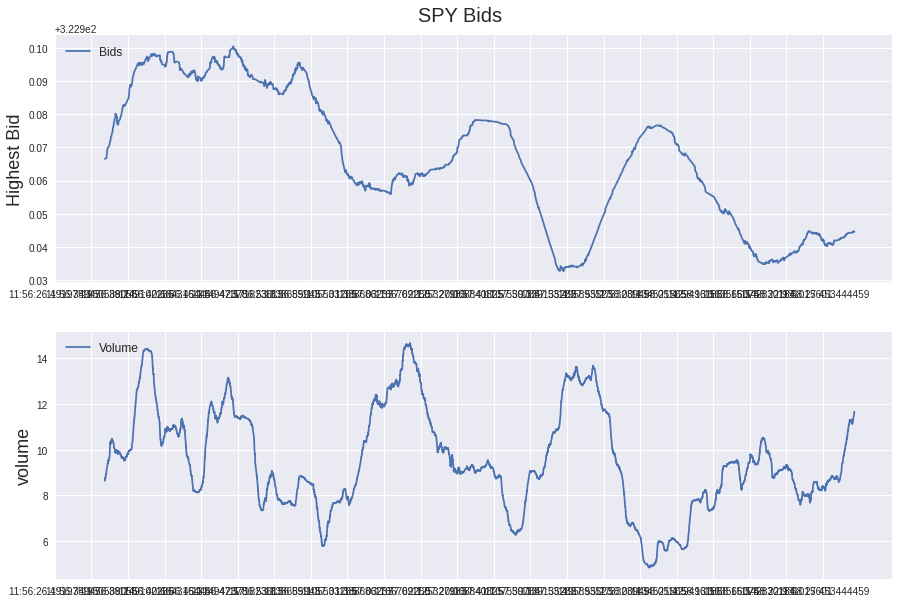

In [5]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['BID'], label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['TIME_M'].loc[::1464])
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['BIDSIZ'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['TIME_M'].loc[::1464])
ax2.set_ylabel('volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [6]:
'''Calculate percentage change'''

# df['BID'] = df['BID'].pct_change()
# df['BIDSIZ'] = df['BIDSIZ'].pct_change()
# df['ASK'] = df['ASK'].pct_change()
# df['ASKSIZ'] = df['ASKSIZ'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


# '''SCALE'''
# multiplier = 1024
# df['BID'] *= multiplier
# df['ASK'] *= multiplier
# df['BIDSIZ'] *= multiplier
# df['ASKSIZ'] *= multiplier

# '''Normalize price columns'''

# min_return = min(df[['BID', 'ASK']].min(axis=0))
# max_return = max(df[['BID', 'ASK']].max(axis=0))

# print(min_return)
# print(max_return)

# # Min-max normalize price columns (0-1 range)
# df['BID'] = (df['BID'] - min_return) / (max_return - min_return)
# df['ASK'] = (df['ASK'] - min_return) / (max_return - min_return)


# '''Normalize volume column'''

# min_volume = min(df[['BIDSIZ', 'ASKSIZ']].min(axis=0))
# max_volume = max(df[['BIDSIZ', 'ASKSIZ']].max(axis=0))

# # Min-max normalize volume columns (0-1 range)
# df['BIDSIZ'] = (df['BIDSIZ'] - min_volume) / (max_volume - min_volume)
# df['ASKSIZ'] = (df['ASKSIZ'] - min_volume) / (max_volume - min_volume)

# print((max_volume - min_volume))

# Remove date, time, symbol column
df.drop(columns=['DATE'], inplace=True)
df.drop(columns=['TIME_M'], inplace=True)
df.drop(columns=['SYM_ROOT'], inplace=True)
df.drop(columns=['BID'], inplace=True)
df.drop(columns=['ASKSIZ'], inplace=True)
df.drop(columns=['ASK'], inplace=True)

df = np.array(df)

In [7]:
# ttime = np.arange(0, len(df), 1)
# amp = np.sin(ttime/10) + 10 * np.sin(ttime*0.005) +np.sin(ttime*0.012) *np.random.normal(-0.2, 0.2, len(ttime))
# amp = amp.reshape(-1, 1)
#df += amp

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1)) 
#amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
df = scaler.fit_transform(df.reshape(-1, 1)).reshape(-1)

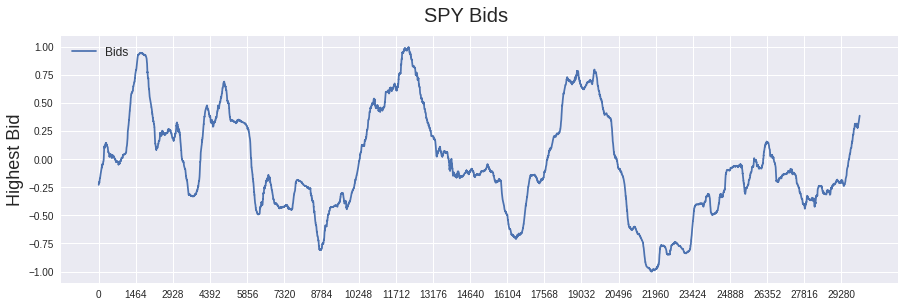

In [9]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df, label='Bids')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

<h2>Loss Function  and Optimizer</h2>

In [10]:
torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

input_window = 128
output_window = 8
batch_size = 10 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [11]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    samples = 24000
    train_data = df[:samples]
    test_data = df[samples:]
    
    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?
    
    print(df.shape)
    print(train_sequence.shape)
    print(test_data.shape)
    
    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth,color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    
    return total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [12]:
train_data, val_data = get_data()
    
model = TransAm(feature_size=128,num_layers=2).to(device)

criterion = nn.MSELoss()
#lr = 0.005 
lr=0.005

#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 5000 # The number of epochs
best_model = None

curr_count = 0

(30001,)
torch.Size([23864, 2, 128])
torch.Size([5865, 2, 128])


In [13]:
for epoch in range(curr_count, curr_count + epochs):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 20 is 0):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step()
curr_count += epochs

| epoch   0 |   477/ 2386 batches | lr 0.005000 | 10.67 ms | loss 0.14808 | ppl     1.16
| epoch   0 |   954/ 2386 batches | lr 0.005000 |  9.38 ms | loss 0.00050 | ppl     1.00
| epoch   0 |  1431/ 2386 batches | lr 0.005000 |  9.35 ms | loss 0.00097 | ppl     1.00
| epoch   0 |  1908/ 2386 batches | lr 0.005000 |  9.40 ms | loss 0.00035 | ppl     1.00
| epoch   0 |  2385/ 2386 batches | lr 0.005000 |  9.38 ms | loss 0.00025 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 33.79s | valid loss 0.06700 | valid ppl     1.07
-----------------------------------------------------------------------------------------
| epoch   1 |   477/ 2386 batches | lr 0.004802 |  9.50 ms | loss 0.00158 | ppl     1.00
| epoch   1 |   954/ 2386 batches | lr 0.004802 |  9.23 ms | loss 0.00116 | ppl     1.00
| epoch   1 |  1431/ 2386 batches | lr 0.004802 |  9.32 ms | loss 0.00099 | ppl     1.00
| epoch   1 |  1908/ 2386 batche

| epoch  12 |   477/ 2386 batches | lr 0.003845 |  9.65 ms | loss 0.00191 | ppl     1.00
| epoch  12 |   954/ 2386 batches | lr 0.003845 |  9.24 ms | loss 0.00119 | ppl     1.00
| epoch  12 |  1431/ 2386 batches | lr 0.003845 |  9.53 ms | loss 0.00151 | ppl     1.00
| epoch  12 |  1908/ 2386 batches | lr 0.003845 |  9.44 ms | loss 0.00109 | ppl     1.00
| epoch  12 |  2385/ 2386 batches | lr 0.003845 |  9.65 ms | loss 0.00090 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 23.38s | valid loss 0.06317 | valid ppl     1.07
-----------------------------------------------------------------------------------------
| epoch  13 |   477/ 2386 batches | lr 0.003768 |  9.39 ms | loss 0.00243 | ppl     1.00
| epoch  13 |   954/ 2386 batches | lr 0.003768 |  9.44 ms | loss 0.00094 | ppl     1.00
| epoch  13 |  1431/ 2386 batches | lr 0.003768 |  9.36 ms | loss 0.00152 | ppl     1.00
| epoch  13 |  1908/ 2386 batche

| epoch  24 |   477/ 2386 batches | lr 0.003017 |  9.34 ms | loss 0.00190 | ppl     1.00
| epoch  24 |   954/ 2386 batches | lr 0.003017 |  9.16 ms | loss 0.00137 | ppl     1.00
| epoch  24 |  1431/ 2386 batches | lr 0.003017 |  9.34 ms | loss 0.00142 | ppl     1.00
| epoch  24 |  1908/ 2386 batches | lr 0.003017 |  9.34 ms | loss 0.00142 | ppl     1.00
| epoch  24 |  2385/ 2386 batches | lr 0.003017 |  9.29 ms | loss 0.00062 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  24 | time: 22.87s | valid loss 0.05314 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch  25 |   477/ 2386 batches | lr 0.002957 |  9.27 ms | loss 0.00214 | ppl     1.00
| epoch  25 |   954/ 2386 batches | lr 0.002957 |  9.37 ms | loss 0.00118 | ppl     1.00
| epoch  25 |  1431/ 2386 batches | lr 0.002957 |  9.32 ms | loss 0.00166 | ppl     1.00
| epoch  25 |  1908/ 2386 batche

| epoch  36 |   477/ 2386 batches | lr 0.002368 |  9.45 ms | loss 0.00196 | ppl     1.00
| epoch  36 |   954/ 2386 batches | lr 0.002368 |  9.14 ms | loss 0.00121 | ppl     1.00
| epoch  36 |  1431/ 2386 batches | lr 0.002368 |  9.32 ms | loss 0.00166 | ppl     1.00
| epoch  36 |  1908/ 2386 batches | lr 0.002368 |  9.36 ms | loss 0.00096 | ppl     1.00
| epoch  36 |  2385/ 2386 batches | lr 0.002368 |  9.20 ms | loss 0.00089 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  36 | time: 22.88s | valid loss 0.05545 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  37 |   477/ 2386 batches | lr 0.002320 |  9.46 ms | loss 0.00238 | ppl     1.00
| epoch  37 |   954/ 2386 batches | lr 0.002320 |  9.24 ms | loss 0.00115 | ppl     1.00
| epoch  37 |  1431/ 2386 batches | lr 0.002320 |  9.33 ms | loss 0.00186 | ppl     1.00
| epoch  37 |  1908/ 2386 batche

| epoch  48 |   477/ 2386 batches | lr 0.001858 |  9.42 ms | loss 0.00525 | ppl     1.01
| epoch  48 |   954/ 2386 batches | lr 0.001858 |  9.75 ms | loss 0.00265 | ppl     1.00
| epoch  48 |  1431/ 2386 batches | lr 0.001858 |  9.75 ms | loss 0.00195 | ppl     1.00
| epoch  48 |  1908/ 2386 batches | lr 0.001858 |  9.67 ms | loss 0.00190 | ppl     1.00
| epoch  48 |  2385/ 2386 batches | lr 0.001858 |  9.79 ms | loss 0.00199 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  48 | time: 23.80s | valid loss 0.05316 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch  49 |   477/ 2386 batches | lr 0.001821 |  9.39 ms | loss 0.00666 | ppl     1.01
| epoch  49 |   954/ 2386 batches | lr 0.001821 |  9.32 ms | loss 0.00353 | ppl     1.00
| epoch  49 |  1431/ 2386 batches | lr 0.001821 |  9.33 ms | loss 0.00226 | ppl     1.00
| epoch  49 |  1908/ 2386 batche

| epoch  60 |   477/ 2386 batches | lr 0.001458 |  9.58 ms | loss 0.01827 | ppl     1.02
| epoch  60 |   954/ 2386 batches | lr 0.001458 |  9.82 ms | loss 0.01461 | ppl     1.01
| epoch  60 |  1431/ 2386 batches | lr 0.001458 |  9.67 ms | loss 0.00619 | ppl     1.01
| epoch  60 |  1908/ 2386 batches | lr 0.001458 |  9.61 ms | loss 0.00416 | ppl     1.00
| epoch  60 |  2385/ 2386 batches | lr 0.001458 |  9.44 ms | loss 0.00533 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 34.31s | valid loss 0.06401 | valid ppl     1.07
-----------------------------------------------------------------------------------------
| epoch  61 |   477/ 2386 batches | lr 0.001429 |  9.62 ms | loss 0.01580 | ppl     1.02
| epoch  61 |   954/ 2386 batches | lr 0.001429 |  9.72 ms | loss 0.01441 | ppl     1.01
| epoch  61 |  1431/ 2386 batches | lr 0.001429 |  9.67 ms | loss 0.00568 | ppl     1.01
| epoch  61 |  1908/ 2386 batche

| epoch  72 |   477/ 2386 batches | lr 0.001144 |  9.53 ms | loss 0.02981 | ppl     1.03
| epoch  72 |   954/ 2386 batches | lr 0.001144 |  9.55 ms | loss 0.02004 | ppl     1.02
| epoch  72 |  1431/ 2386 batches | lr 0.001144 |  9.47 ms | loss 0.00729 | ppl     1.01
| epoch  72 |  1908/ 2386 batches | lr 0.001144 |  9.48 ms | loss 0.00828 | ppl     1.01
| epoch  72 |  2385/ 2386 batches | lr 0.001144 |  9.45 ms | loss 0.00742 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch  72 | time: 23.36s | valid loss 0.06275 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch  73 |   477/ 2386 batches | lr 0.001121 |  9.58 ms | loss 0.03394 | ppl     1.03
| epoch  73 |   954/ 2386 batches | lr 0.001121 |  9.49 ms | loss 0.03116 | ppl     1.03
| epoch  73 |  1431/ 2386 batches | lr 0.001121 |  9.39 ms | loss 0.00949 | ppl     1.01
| epoch  73 |  1908/ 2386 batche

| epoch  84 |   477/ 2386 batches | lr 0.000898 |  9.66 ms | loss 0.08538 | ppl     1.09
| epoch  84 |   954/ 2386 batches | lr 0.000898 |  9.48 ms | loss 0.04454 | ppl     1.05
| epoch  84 |  1431/ 2386 batches | lr 0.000898 |  9.38 ms | loss 0.01583 | ppl     1.02
| epoch  84 |  1908/ 2386 batches | lr 0.000898 |  9.45 ms | loss 0.01940 | ppl     1.02
| epoch  84 |  2385/ 2386 batches | lr 0.000898 |  9.42 ms | loss 0.00233 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch  84 | time: 23.31s | valid loss 0.06651 | valid ppl     1.07
-----------------------------------------------------------------------------------------
| epoch  85 |   477/ 2386 batches | lr 0.000880 |  9.54 ms | loss 0.01380 | ppl     1.01
| epoch  85 |   954/ 2386 batches | lr 0.000880 |  9.54 ms | loss 0.02265 | ppl     1.02
| epoch  85 |  1431/ 2386 batches | lr 0.000880 |  9.49 ms | loss 0.00748 | ppl     1.01
| epoch  85 |  1908/ 2386 batche

| epoch  96 |   477/ 2386 batches | lr 0.000705 |  8.57 ms | loss 0.11214 | ppl     1.12
| epoch  96 |   954/ 2386 batches | lr 0.000705 |  8.49 ms | loss 0.05253 | ppl     1.05
| epoch  96 |  1431/ 2386 batches | lr 0.000705 |  9.02 ms | loss 0.02454 | ppl     1.02
| epoch  96 |  1908/ 2386 batches | lr 0.000705 |  9.34 ms | loss 0.03668 | ppl     1.04
| epoch  96 |  2385/ 2386 batches | lr 0.000705 |  9.46 ms | loss 0.05924 | ppl     1.06
-----------------------------------------------------------------------------------------
| end of epoch  96 | time: 22.11s | valid loss 0.08019 | valid ppl     1.08
-----------------------------------------------------------------------------------------
| epoch  97 |   477/ 2386 batches | lr 0.000690 |  9.61 ms | loss 0.11550 | ppl     1.12
| epoch  97 |   954/ 2386 batches | lr 0.000690 |  9.39 ms | loss 0.05305 | ppl     1.05
| epoch  97 |  1431/ 2386 batches | lr 0.000690 |  9.42 ms | loss 0.02686 | ppl     1.03
| epoch  97 |  1908/ 2386 batche

| epoch 108 |   477/ 2386 batches | lr 0.000553 |  9.78 ms | loss 0.12134 | ppl     1.13
| epoch 108 |   954/ 2386 batches | lr 0.000553 |  9.69 ms | loss 0.06801 | ppl     1.07
| epoch 108 |  1431/ 2386 batches | lr 0.000553 |  9.62 ms | loss 0.03628 | ppl     1.04
| epoch 108 |  1908/ 2386 batches | lr 0.000553 |  9.46 ms | loss 0.04524 | ppl     1.05
| epoch 108 |  2385/ 2386 batches | lr 0.000553 |  9.71 ms | loss 0.09197 | ppl     1.10
-----------------------------------------------------------------------------------------
| end of epoch 108 | time: 23.73s | valid loss 0.08436 | valid ppl     1.09
-----------------------------------------------------------------------------------------
| epoch 109 |   477/ 2386 batches | lr 0.000542 |  9.83 ms | loss 0.12012 | ppl     1.13
| epoch 109 |   954/ 2386 batches | lr 0.000542 |  9.75 ms | loss 0.07735 | ppl     1.08
| epoch 109 |  1431/ 2386 batches | lr 0.000542 |  9.63 ms | loss 0.04079 | ppl     1.04
| epoch 109 |  1908/ 2386 batche

| epoch 120 |   477/ 2386 batches | lr 0.000434 |  9.73 ms | loss 0.14691 | ppl     1.16
| epoch 120 |   954/ 2386 batches | lr 0.000434 |  9.66 ms | loss 0.08630 | ppl     1.09
| epoch 120 |  1431/ 2386 batches | lr 0.000434 |  9.44 ms | loss 0.04664 | ppl     1.05
| epoch 120 |  1908/ 2386 batches | lr 0.000434 |  9.57 ms | loss 0.00695 | ppl     1.01
| epoch 120 |  2385/ 2386 batches | lr 0.000434 |  9.52 ms | loss 0.05307 | ppl     1.05
-----------------------------------------------------------------------------------------
| end of epoch 120 | time: 33.70s | valid loss 0.08332 | valid ppl     1.09
-----------------------------------------------------------------------------------------
| epoch 121 |   477/ 2386 batches | lr 0.000425 |  9.19 ms | loss 0.10236 | ppl     1.11
| epoch 121 |   954/ 2386 batches | lr 0.000425 |  9.90 ms | loss 0.02484 | ppl     1.03
| epoch 121 |  1431/ 2386 batches | lr 0.000425 |  9.85 ms | loss 0.01483 | ppl     1.01
| epoch 121 |  1908/ 2386 batche

| epoch 132 |   477/ 2386 batches | lr 0.000340 |  9.91 ms | loss 0.01810 | ppl     1.02
| epoch 132 |   954/ 2386 batches | lr 0.000340 |  9.60 ms | loss 0.00956 | ppl     1.01
| epoch 132 |  1431/ 2386 batches | lr 0.000340 |  9.41 ms | loss 0.00640 | ppl     1.01
| epoch 132 |  1908/ 2386 batches | lr 0.000340 |  9.24 ms | loss 0.00346 | ppl     1.00
| epoch 132 |  2385/ 2386 batches | lr 0.000340 |  9.57 ms | loss 0.00750 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch 132 | time: 23.48s | valid loss 0.06119 | valid ppl     1.06
-----------------------------------------------------------------------------------------
| epoch 133 |   477/ 2386 batches | lr 0.000334 |  9.41 ms | loss 0.01631 | ppl     1.02
| epoch 133 |   954/ 2386 batches | lr 0.000334 |  9.54 ms | loss 0.00771 | ppl     1.01
| epoch 133 |  1431/ 2386 batches | lr 0.000334 |  9.42 ms | loss 0.00540 | ppl     1.01
| epoch 133 |  1908/ 2386 batche

| epoch 144 |   477/ 2386 batches | lr 0.000267 |  9.40 ms | loss 0.00395 | ppl     1.00
| epoch 144 |   954/ 2386 batches | lr 0.000267 |  9.37 ms | loss 0.00270 | ppl     1.00
| epoch 144 |  1431/ 2386 batches | lr 0.000267 |  9.31 ms | loss 0.00259 | ppl     1.00
| epoch 144 |  1908/ 2386 batches | lr 0.000267 |  9.82 ms | loss 0.00198 | ppl     1.00
| epoch 144 |  2385/ 2386 batches | lr 0.000267 |  9.34 ms | loss 0.00301 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 144 | time: 23.29s | valid loss 0.02693 | valid ppl     1.03
-----------------------------------------------------------------------------------------
| epoch 145 |   477/ 2386 batches | lr 0.000262 |  9.50 ms | loss 0.00438 | ppl     1.00
| epoch 145 |   954/ 2386 batches | lr 0.000262 | 10.06 ms | loss 0.00268 | ppl     1.00
| epoch 145 |  1431/ 2386 batches | lr 0.000262 |  9.72 ms | loss 0.00332 | ppl     1.00
| epoch 145 |  1908/ 2386 batche

| epoch 156 |   477/ 2386 batches | lr 0.000210 |  8.45 ms | loss 0.00195 | ppl     1.00
| epoch 156 |   954/ 2386 batches | lr 0.000210 |  8.43 ms | loss 0.00220 | ppl     1.00
| epoch 156 |  1431/ 2386 batches | lr 0.000210 |  8.43 ms | loss 0.00192 | ppl     1.00
| epoch 156 |  1908/ 2386 batches | lr 0.000210 |  8.44 ms | loss 0.00175 | ppl     1.00
| epoch 156 |  2385/ 2386 batches | lr 0.000210 |  8.44 ms | loss 0.00274 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 156 | time: 20.84s | valid loss 0.01303 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch 157 |   477/ 2386 batches | lr 0.000205 |  8.47 ms | loss 0.00220 | ppl     1.00
| epoch 157 |   954/ 2386 batches | lr 0.000205 |  8.44 ms | loss 0.00212 | ppl     1.00
| epoch 157 |  1431/ 2386 batches | lr 0.000205 |  8.43 ms | loss 0.00179 | ppl     1.00
| epoch 157 |  1908/ 2386 batche

| epoch 168 |   477/ 2386 batches | lr 0.000165 |  9.42 ms | loss 0.00184 | ppl     1.00
| epoch 168 |   954/ 2386 batches | lr 0.000165 |  9.37 ms | loss 0.00172 | ppl     1.00
| epoch 168 |  1431/ 2386 batches | lr 0.000165 |  9.42 ms | loss 0.00187 | ppl     1.00
| epoch 168 |  1908/ 2386 batches | lr 0.000165 |  9.35 ms | loss 0.00137 | ppl     1.00
| epoch 168 |  2385/ 2386 batches | lr 0.000165 |  9.42 ms | loss 0.00258 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 168 | time: 23.12s | valid loss 0.01166 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch 169 |   477/ 2386 batches | lr 0.000161 |  9.34 ms | loss 0.00164 | ppl     1.00
| epoch 169 |   954/ 2386 batches | lr 0.000161 |  9.38 ms | loss 0.00174 | ppl     1.00
| epoch 169 |  1431/ 2386 batches | lr 0.000161 |  9.38 ms | loss 0.00190 | ppl     1.00
| epoch 169 |  1908/ 2386 batche

| epoch 180 |   477/ 2386 batches | lr 0.000129 |  9.30 ms | loss 0.00138 | ppl     1.00
| epoch 180 |   954/ 2386 batches | lr 0.000129 |  9.31 ms | loss 0.00138 | ppl     1.00
| epoch 180 |  1431/ 2386 batches | lr 0.000129 |  9.17 ms | loss 0.00154 | ppl     1.00
| epoch 180 |  1908/ 2386 batches | lr 0.000129 |  9.27 ms | loss 0.00099 | ppl     1.00
| epoch 180 |  2385/ 2386 batches | lr 0.000129 |  9.29 ms | loss 0.00215 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 180 | time: 32.88s | valid loss 0.00566 | valid ppl     1.01
-----------------------------------------------------------------------------------------
| epoch 181 |   477/ 2386 batches | lr 0.000127 |  9.43 ms | loss 0.00130 | ppl     1.00
| epoch 181 |   954/ 2386 batches | lr 0.000127 |  9.54 ms | loss 0.00122 | ppl     1.00
| epoch 181 |  1431/ 2386 batches | lr 0.000127 |  9.29 ms | loss 0.00138 | ppl     1.00
| epoch 181 |  1908/ 2386 batche

| epoch 192 |   477/ 2386 batches | lr 0.000101 |  9.40 ms | loss 0.00110 | ppl     1.00
| epoch 192 |   954/ 2386 batches | lr 0.000101 |  9.46 ms | loss 0.00097 | ppl     1.00
| epoch 192 |  1431/ 2386 batches | lr 0.000101 |  9.41 ms | loss 0.00112 | ppl     1.00
| epoch 192 |  1908/ 2386 batches | lr 0.000101 |  9.56 ms | loss 0.00074 | ppl     1.00
| epoch 192 |  2385/ 2386 batches | lr 0.000101 |  9.56 ms | loss 0.00170 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 192 | time: 23.32s | valid loss 0.00388 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 193 |   477/ 2386 batches | lr 0.000099 |  9.40 ms | loss 0.00109 | ppl     1.00
| epoch 193 |   954/ 2386 batches | lr 0.000099 |  9.41 ms | loss 0.00097 | ppl     1.00
| epoch 193 |  1431/ 2386 batches | lr 0.000099 |  9.33 ms | loss 0.00111 | ppl     1.00
| epoch 193 |  1908/ 2386 batche

| epoch 204 |   477/ 2386 batches | lr 0.000079 |  9.68 ms | loss 0.00088 | ppl     1.00
| epoch 204 |   954/ 2386 batches | lr 0.000079 |  9.67 ms | loss 0.00082 | ppl     1.00
| epoch 204 |  1431/ 2386 batches | lr 0.000079 |  9.69 ms | loss 0.00088 | ppl     1.00
| epoch 204 |  1908/ 2386 batches | lr 0.000079 |  9.48 ms | loss 0.00064 | ppl     1.00
| epoch 204 |  2385/ 2386 batches | lr 0.000079 |  9.54 ms | loss 0.00133 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 204 | time: 23.66s | valid loss 0.00288 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 205 |   477/ 2386 batches | lr 0.000078 |  9.35 ms | loss 0.00086 | ppl     1.00
| epoch 205 |   954/ 2386 batches | lr 0.000078 |  8.70 ms | loss 0.00078 | ppl     1.00
| epoch 205 |  1431/ 2386 batches | lr 0.000078 |  9.69 ms | loss 0.00088 | ppl     1.00
| epoch 205 |  1908/ 2386 batche

| epoch 216 |   477/ 2386 batches | lr 0.000062 |  9.41 ms | loss 0.00076 | ppl     1.00
| epoch 216 |   954/ 2386 batches | lr 0.000062 |  9.31 ms | loss 0.00069 | ppl     1.00
| epoch 216 |  1431/ 2386 batches | lr 0.000062 |  9.29 ms | loss 0.00076 | ppl     1.00
| epoch 216 |  1908/ 2386 batches | lr 0.000062 |  9.40 ms | loss 0.00057 | ppl     1.00
| epoch 216 |  2385/ 2386 batches | lr 0.000062 |  9.32 ms | loss 0.00115 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 216 | time: 23.01s | valid loss 0.00224 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 217 |   477/ 2386 batches | lr 0.000061 |  9.36 ms | loss 0.00076 | ppl     1.00
| epoch 217 |   954/ 2386 batches | lr 0.000061 |  9.34 ms | loss 0.00071 | ppl     1.00
| epoch 217 |  1431/ 2386 batches | lr 0.000061 |  9.45 ms | loss 0.00076 | ppl     1.00
| epoch 217 |  1908/ 2386 batche

| epoch 228 |   477/ 2386 batches | lr 0.000049 |  9.41 ms | loss 0.00064 | ppl     1.00
| epoch 228 |   954/ 2386 batches | lr 0.000049 |  9.30 ms | loss 0.00063 | ppl     1.00
| epoch 228 |  1431/ 2386 batches | lr 0.000049 |  9.26 ms | loss 0.00068 | ppl     1.00
| epoch 228 |  1908/ 2386 batches | lr 0.000049 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 228 |  2385/ 2386 batches | lr 0.000049 |  9.33 ms | loss 0.00104 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 228 | time: 22.98s | valid loss 0.00138 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 229 |   477/ 2386 batches | lr 0.000048 |  9.06 ms | loss 0.00066 | ppl     1.00
| epoch 229 |   954/ 2386 batches | lr 0.000048 |  8.32 ms | loss 0.00061 | ppl     1.00
| epoch 229 |  1431/ 2386 batches | lr 0.000048 |  8.32 ms | loss 0.00068 | ppl     1.00
| epoch 229 |  1908/ 2386 batche

| epoch 240 |   477/ 2386 batches | lr 0.000038 |  9.36 ms | loss 0.00060 | ppl     1.00
| epoch 240 |   954/ 2386 batches | lr 0.000038 |  9.42 ms | loss 0.00056 | ppl     1.00
| epoch 240 |  1431/ 2386 batches | lr 0.000038 |  9.26 ms | loss 0.00062 | ppl     1.00
| epoch 240 |  1908/ 2386 batches | lr 0.000038 |  9.34 ms | loss 0.00048 | ppl     1.00
| epoch 240 |  2385/ 2386 batches | lr 0.000038 |  9.31 ms | loss 0.00094 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 240 | time: 33.08s | valid loss 0.00101 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 241 |   477/ 2386 batches | lr 0.000038 |  9.35 ms | loss 0.00058 | ppl     1.00
| epoch 241 |   954/ 2386 batches | lr 0.000038 |  9.34 ms | loss 0.00054 | ppl     1.00
| epoch 241 |  1431/ 2386 batches | lr 0.000038 |  9.35 ms | loss 0.00063 | ppl     1.00
| epoch 241 |  1908/ 2386 batche

| epoch 252 |   477/ 2386 batches | lr 0.000030 |  9.22 ms | loss 0.00055 | ppl     1.00
| epoch 252 |   954/ 2386 batches | lr 0.000030 |  9.26 ms | loss 0.00052 | ppl     1.00
| epoch 252 |  1431/ 2386 batches | lr 0.000030 |  9.34 ms | loss 0.00059 | ppl     1.00
| epoch 252 |  1908/ 2386 batches | lr 0.000030 |  9.31 ms | loss 0.00046 | ppl     1.00
| epoch 252 |  2385/ 2386 batches | lr 0.000030 |  9.35 ms | loss 0.00087 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 252 | time: 22.88s | valid loss 0.00097 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 253 |   477/ 2386 batches | lr 0.000030 |  9.30 ms | loss 0.00055 | ppl     1.00
| epoch 253 |   954/ 2386 batches | lr 0.000030 |  9.30 ms | loss 0.00052 | ppl     1.00
| epoch 253 |  1431/ 2386 batches | lr 0.000030 |  9.25 ms | loss 0.00059 | ppl     1.00
| epoch 253 |  1908/ 2386 batche

| epoch 264 |   477/ 2386 batches | lr 0.000024 |  9.31 ms | loss 0.00052 | ppl     1.00
| epoch 264 |   954/ 2386 batches | lr 0.000024 |  9.22 ms | loss 0.00050 | ppl     1.00
| epoch 264 |  1431/ 2386 batches | lr 0.000024 |  9.26 ms | loss 0.00057 | ppl     1.00
| epoch 264 |  1908/ 2386 batches | lr 0.000024 |  9.23 ms | loss 0.00044 | ppl     1.00
| epoch 264 |  2385/ 2386 batches | lr 0.000024 |  9.21 ms | loss 0.00081 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 264 | time: 22.76s | valid loss 0.00081 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 265 |   477/ 2386 batches | lr 0.000023 |  9.45 ms | loss 0.00051 | ppl     1.00
| epoch 265 |   954/ 2386 batches | lr 0.000023 |  9.26 ms | loss 0.00049 | ppl     1.00
| epoch 265 |  1431/ 2386 batches | lr 0.000023 |  9.29 ms | loss 0.00056 | ppl     1.00
| epoch 265 |  1908/ 2386 batche

| epoch 276 |   477/ 2386 batches | lr 0.000019 |  9.28 ms | loss 0.00050 | ppl     1.00
| epoch 276 |   954/ 2386 batches | lr 0.000019 |  9.35 ms | loss 0.00047 | ppl     1.00
| epoch 276 |  1431/ 2386 batches | lr 0.000019 |  9.34 ms | loss 0.00055 | ppl     1.00
| epoch 276 |  1908/ 2386 batches | lr 0.000019 |  9.42 ms | loss 0.00042 | ppl     1.00
| epoch 276 |  2385/ 2386 batches | lr 0.000019 |  9.25 ms | loss 0.00077 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 276 | time: 22.96s | valid loss 0.00082 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 277 |   477/ 2386 batches | lr 0.000018 |  9.35 ms | loss 0.00049 | ppl     1.00
| epoch 277 |   954/ 2386 batches | lr 0.000018 |  9.25 ms | loss 0.00047 | ppl     1.00
| epoch 277 |  1431/ 2386 batches | lr 0.000018 |  9.31 ms | loss 0.00054 | ppl     1.00
| epoch 277 |  1908/ 2386 batche

| epoch 288 |   477/ 2386 batches | lr 0.000015 |  9.26 ms | loss 0.00049 | ppl     1.00
| epoch 288 |   954/ 2386 batches | lr 0.000015 |  9.38 ms | loss 0.00046 | ppl     1.00
| epoch 288 |  1431/ 2386 batches | lr 0.000015 |  9.36 ms | loss 0.00054 | ppl     1.00
| epoch 288 |  1908/ 2386 batches | lr 0.000015 |  9.21 ms | loss 0.00042 | ppl     1.00
| epoch 288 |  2385/ 2386 batches | lr 0.000015 |  9.25 ms | loss 0.00075 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 288 | time: 22.87s | valid loss 0.00077 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 289 |   477/ 2386 batches | lr 0.000014 |  9.17 ms | loss 0.00048 | ppl     1.00
| epoch 289 |   954/ 2386 batches | lr 0.000014 |  9.25 ms | loss 0.00046 | ppl     1.00
| epoch 289 |  1431/ 2386 batches | lr 0.000014 |  9.27 ms | loss 0.00053 | ppl     1.00
| epoch 289 |  1908/ 2386 batche

| epoch 300 |   477/ 2386 batches | lr 0.000011 |  9.24 ms | loss 0.00047 | ppl     1.00
| epoch 300 |   954/ 2386 batches | lr 0.000011 |  9.25 ms | loss 0.00044 | ppl     1.00
| epoch 300 |  1431/ 2386 batches | lr 0.000011 |  9.36 ms | loss 0.00053 | ppl     1.00
| epoch 300 |  1908/ 2386 batches | lr 0.000011 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 300 |  2385/ 2386 batches | lr 0.000011 |  9.47 ms | loss 0.00072 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 300 | time: 33.23s | valid loss 0.00068 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 301 |   477/ 2386 batches | lr 0.000011 |  9.50 ms | loss 0.00047 | ppl     1.00
| epoch 301 |   954/ 2386 batches | lr 0.000011 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 301 |  1431/ 2386 batches | lr 0.000011 |  9.41 ms | loss 0.00054 | ppl     1.00
| epoch 301 |  1908/ 2386 batche

| epoch 312 |   477/ 2386 batches | lr 0.000009 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 312 |   954/ 2386 batches | lr 0.000009 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 312 |  1431/ 2386 batches | lr 0.000009 |  9.41 ms | loss 0.00052 | ppl     1.00
| epoch 312 |  1908/ 2386 batches | lr 0.000009 |  9.16 ms | loss 0.00040 | ppl     1.00
| epoch 312 |  2385/ 2386 batches | lr 0.000009 |  9.33 ms | loss 0.00071 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 312 | time: 22.99s | valid loss 0.00062 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 313 |   477/ 2386 batches | lr 0.000009 |  9.39 ms | loss 0.00046 | ppl     1.00
| epoch 313 |   954/ 2386 batches | lr 0.000009 |  9.30 ms | loss 0.00043 | ppl     1.00
| epoch 313 |  1431/ 2386 batches | lr 0.000009 |  9.22 ms | loss 0.00052 | ppl     1.00
| epoch 313 |  1908/ 2386 batche

| epoch 324 |   477/ 2386 batches | lr 0.000007 |  8.38 ms | loss 0.00046 | ppl     1.00
| epoch 324 |   954/ 2386 batches | lr 0.000007 |  8.36 ms | loss 0.00043 | ppl     1.00
| epoch 324 |  1431/ 2386 batches | lr 0.000007 |  8.36 ms | loss 0.00052 | ppl     1.00
| epoch 324 |  1908/ 2386 batches | lr 0.000007 |  8.37 ms | loss 0.00040 | ppl     1.00
| epoch 324 |  2385/ 2386 batches | lr 0.000007 |  9.23 ms | loss 0.00068 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 324 | time: 21.07s | valid loss 0.00057 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 325 |   477/ 2386 batches | lr 0.000007 |  9.29 ms | loss 0.00046 | ppl     1.00
| epoch 325 |   954/ 2386 batches | lr 0.000007 |  9.38 ms | loss 0.00043 | ppl     1.00
| epoch 325 |  1431/ 2386 batches | lr 0.000007 |  9.29 ms | loss 0.00052 | ppl     1.00
| epoch 325 |  1908/ 2386 batche

| epoch 336 |   477/ 2386 batches | lr 0.000006 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 336 |   954/ 2386 batches | lr 0.000006 |  9.33 ms | loss 0.00042 | ppl     1.00
| epoch 336 |  1431/ 2386 batches | lr 0.000006 |  9.49 ms | loss 0.00052 | ppl     1.00
| epoch 336 |  1908/ 2386 batches | lr 0.000006 |  9.49 ms | loss 0.00040 | ppl     1.00
| epoch 336 |  2385/ 2386 batches | lr 0.000006 |  9.40 ms | loss 0.00068 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 336 | time: 23.20s | valid loss 0.00056 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 337 |   477/ 2386 batches | lr 0.000005 |  9.59 ms | loss 0.00046 | ppl     1.00
| epoch 337 |   954/ 2386 batches | lr 0.000005 |  9.39 ms | loss 0.00043 | ppl     1.00
| epoch 337 |  1431/ 2386 batches | lr 0.000005 |  9.45 ms | loss 0.00052 | ppl     1.00
| epoch 337 |  1908/ 2386 batche

| epoch 348 |   477/ 2386 batches | lr 0.000004 |  9.44 ms | loss 0.00045 | ppl     1.00
| epoch 348 |   954/ 2386 batches | lr 0.000004 |  9.26 ms | loss 0.00042 | ppl     1.00
| epoch 348 |  1431/ 2386 batches | lr 0.000004 |  9.30 ms | loss 0.00052 | ppl     1.00
| epoch 348 |  1908/ 2386 batches | lr 0.000004 |  9.28 ms | loss 0.00039 | ppl     1.00
| epoch 348 |  2385/ 2386 batches | lr 0.000004 |  9.34 ms | loss 0.00067 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 348 | time: 22.95s | valid loss 0.00053 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 349 |   477/ 2386 batches | lr 0.000004 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 349 |   954/ 2386 batches | lr 0.000004 |  9.39 ms | loss 0.00042 | ppl     1.00
| epoch 349 |  1431/ 2386 batches | lr 0.000004 |  9.31 ms | loss 0.00053 | ppl     1.00
| epoch 349 |  1908/ 2386 batche

| epoch 360 |   477/ 2386 batches | lr 0.000003 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 360 |   954/ 2386 batches | lr 0.000003 |  9.38 ms | loss 0.00042 | ppl     1.00
| epoch 360 |  1431/ 2386 batches | lr 0.000003 |  9.30 ms | loss 0.00050 | ppl     1.00
| epoch 360 |  1908/ 2386 batches | lr 0.000003 |  9.38 ms | loss 0.00039 | ppl     1.00
| epoch 360 |  2385/ 2386 batches | lr 0.000003 |  9.36 ms | loss 0.00067 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 360 | time: 33.12s | valid loss 0.00049 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 361 |   477/ 2386 batches | lr 0.000003 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 361 |   954/ 2386 batches | lr 0.000003 |  9.33 ms | loss 0.00041 | ppl     1.00
| epoch 361 |  1431/ 2386 batches | lr 0.000003 |  9.35 ms | loss 0.00052 | ppl     1.00
| epoch 361 |  1908/ 2386 batche

| epoch 372 |   477/ 2386 batches | lr 0.000003 |  8.38 ms | loss 0.00045 | ppl     1.00
| epoch 372 |   954/ 2386 batches | lr 0.000003 |  8.36 ms | loss 0.00042 | ppl     1.00
| epoch 372 |  1431/ 2386 batches | lr 0.000003 |  8.36 ms | loss 0.00052 | ppl     1.00
| epoch 372 |  1908/ 2386 batches | lr 0.000003 |  8.37 ms | loss 0.00039 | ppl     1.00
| epoch 372 |  2385/ 2386 batches | lr 0.000003 |  8.37 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 372 | time: 20.67s | valid loss 0.00048 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 373 |   477/ 2386 batches | lr 0.000003 |  8.40 ms | loss 0.00045 | ppl     1.00
| epoch 373 |   954/ 2386 batches | lr 0.000003 |  8.36 ms | loss 0.00042 | ppl     1.00
| epoch 373 |  1431/ 2386 batches | lr 0.000003 |  8.36 ms | loss 0.00052 | ppl     1.00
| epoch 373 |  1908/ 2386 batche

| epoch 384 |   477/ 2386 batches | lr 0.000002 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 384 |   954/ 2386 batches | lr 0.000002 |  9.47 ms | loss 0.00042 | ppl     1.00
| epoch 384 |  1431/ 2386 batches | lr 0.000002 |  9.42 ms | loss 0.00051 | ppl     1.00
| epoch 384 |  1908/ 2386 batches | lr 0.000002 |  9.43 ms | loss 0.00040 | ppl     1.00
| epoch 384 |  2385/ 2386 batches | lr 0.000002 |  9.37 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 384 | time: 23.16s | valid loss 0.00047 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 385 |   477/ 2386 batches | lr 0.000002 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 385 |   954/ 2386 batches | lr 0.000002 |  9.36 ms | loss 0.00042 | ppl     1.00
| epoch 385 |  1431/ 2386 batches | lr 0.000002 |  9.47 ms | loss 0.00051 | ppl     1.00
| epoch 385 |  1908/ 2386 batche

| epoch 396 |   477/ 2386 batches | lr 0.000002 |  9.47 ms | loss 0.00046 | ppl     1.00
| epoch 396 |   954/ 2386 batches | lr 0.000002 |  9.46 ms | loss 0.00042 | ppl     1.00
| epoch 396 |  1431/ 2386 batches | lr 0.000002 |  9.46 ms | loss 0.00051 | ppl     1.00
| epoch 396 |  1908/ 2386 batches | lr 0.000002 |  9.36 ms | loss 0.00038 | ppl     1.00
| epoch 396 |  2385/ 2386 batches | lr 0.000002 |  9.39 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 396 | time: 23.25s | valid loss 0.00047 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 397 |   477/ 2386 batches | lr 0.000002 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 397 |   954/ 2386 batches | lr 0.000002 |  9.30 ms | loss 0.00042 | ppl     1.00
| epoch 397 |  1431/ 2386 batches | lr 0.000002 |  9.19 ms | loss 0.00051 | ppl     1.00
| epoch 397 |  1908/ 2386 batche

| epoch 408 |   477/ 2386 batches | lr 0.000001 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 408 |   954/ 2386 batches | lr 0.000001 |  9.46 ms | loss 0.00041 | ppl     1.00
| epoch 408 |  1431/ 2386 batches | lr 0.000001 |  9.46 ms | loss 0.00051 | ppl     1.00
| epoch 408 |  1908/ 2386 batches | lr 0.000001 |  9.34 ms | loss 0.00039 | ppl     1.00
| epoch 408 |  2385/ 2386 batches | lr 0.000001 |  9.37 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 408 | time: 23.19s | valid loss 0.00045 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 409 |   477/ 2386 batches | lr 0.000001 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 409 |   954/ 2386 batches | lr 0.000001 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 409 |  1431/ 2386 batches | lr 0.000001 |  9.58 ms | loss 0.00050 | ppl     1.00
| epoch 409 |  1908/ 2386 batche

| epoch 420 |   477/ 2386 batches | lr 0.000001 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 420 |   954/ 2386 batches | lr 0.000001 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 420 |  1431/ 2386 batches | lr 0.000001 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 420 |  1908/ 2386 batches | lr 0.000001 |  9.25 ms | loss 0.00038 | ppl     1.00
| epoch 420 |  2385/ 2386 batches | lr 0.000001 |  9.34 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 420 | time: 32.99s | valid loss 0.00045 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 421 |   477/ 2386 batches | lr 0.000001 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 421 |   954/ 2386 batches | lr 0.000001 |  9.45 ms | loss 0.00042 | ppl     1.00
| epoch 421 |  1431/ 2386 batches | lr 0.000001 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 421 |  1908/ 2386 batche

| epoch 432 |   477/ 2386 batches | lr 0.000001 |  9.49 ms | loss 0.00046 | ppl     1.00
| epoch 432 |   954/ 2386 batches | lr 0.000001 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 432 |  1431/ 2386 batches | lr 0.000001 |  9.53 ms | loss 0.00050 | ppl     1.00
| epoch 432 |  1908/ 2386 batches | lr 0.000001 |  9.33 ms | loss 0.00038 | ppl     1.00
| epoch 432 |  2385/ 2386 batches | lr 0.000001 |  9.39 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 432 | time: 23.24s | valid loss 0.00044 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 433 |   477/ 2386 batches | lr 0.000001 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 433 |   954/ 2386 batches | lr 0.000001 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 433 |  1431/ 2386 batches | lr 0.000001 |  9.27 ms | loss 0.00051 | ppl     1.00
| epoch 433 |  1908/ 2386 batche

| epoch 444 |   477/ 2386 batches | lr 0.000001 |  9.33 ms | loss 0.00045 | ppl     1.00
| epoch 444 |   954/ 2386 batches | lr 0.000001 |  9.20 ms | loss 0.00041 | ppl     1.00
| epoch 444 |  1431/ 2386 batches | lr 0.000001 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 444 |  1908/ 2386 batches | lr 0.000001 |  9.30 ms | loss 0.00038 | ppl     1.00
| epoch 444 |  2385/ 2386 batches | lr 0.000001 |  9.19 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 444 | time: 22.83s | valid loss 0.00044 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 445 |   477/ 2386 batches | lr 0.000001 |  9.28 ms | loss 0.00045 | ppl     1.00
| epoch 445 |   954/ 2386 batches | lr 0.000001 |  9.49 ms | loss 0.00041 | ppl     1.00
| epoch 445 |  1431/ 2386 batches | lr 0.000001 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 445 |  1908/ 2386 batche

| epoch 456 |   477/ 2386 batches | lr 0.000000 |  8.39 ms | loss 0.00046 | ppl     1.00
| epoch 456 |   954/ 2386 batches | lr 0.000000 |  8.33 ms | loss 0.00041 | ppl     1.00
| epoch 456 |  1431/ 2386 batches | lr 0.000000 |  9.09 ms | loss 0.00050 | ppl     1.00
| epoch 456 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 456 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 456 | time: 21.91s | valid loss 0.00044 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 457 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 457 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 457 |  1431/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00051 | ppl     1.00
| epoch 457 |  1908/ 2386 batche

| epoch 468 |   477/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00045 | ppl     1.00
| epoch 468 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 468 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00051 | ppl     1.00
| epoch 468 |  1908/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00039 | ppl     1.00
| epoch 468 |  2385/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 468 | time: 23.27s | valid loss 0.00043 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 469 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 469 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 469 |  1431/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00051 | ppl     1.00
| epoch 469 |  1908/ 2386 batche

| epoch 480 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00045 | ppl     1.00
| epoch 480 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 480 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00051 | ppl     1.00
| epoch 480 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 480 |  2385/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 480 | time: 33.19s | valid loss 0.00043 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 481 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 481 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00042 | ppl     1.00
| epoch 481 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 481 |  1908/ 2386 batche

| epoch 492 |   477/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 492 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 492 |  1431/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00050 | ppl     1.00
| epoch 492 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00038 | ppl     1.00
| epoch 492 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 492 | time: 23.21s | valid loss 0.00043 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 493 |   477/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00045 | ppl     1.00
| epoch 493 |   954/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00041 | ppl     1.00
| epoch 493 |  1431/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00050 | ppl     1.00
| epoch 493 |  1908/ 2386 batche

| epoch 504 |   477/ 2386 batches | lr 0.000000 |  8.61 ms | loss 0.00045 | ppl     1.00
| epoch 504 |   954/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00041 | ppl     1.00
| epoch 504 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00051 | ppl     1.00
| epoch 504 |  1908/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00038 | ppl     1.00
| epoch 504 |  2385/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00063 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 504 | time: 20.75s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 505 |   477/ 2386 batches | lr 0.000000 |  8.38 ms | loss 0.00045 | ppl     1.00
| epoch 505 |   954/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00041 | ppl     1.00
| epoch 505 |  1431/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00050 | ppl     1.00
| epoch 505 |  1908/ 2386 batche

| epoch 516 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00044 | ppl     1.00
| epoch 516 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00041 | ppl     1.00
| epoch 516 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00051 | ppl     1.00
| epoch 516 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00038 | ppl     1.00
| epoch 516 |  2385/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 516 | time: 23.14s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 517 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 517 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00041 | ppl     1.00
| epoch 517 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 517 |  1908/ 2386 batche

| epoch 528 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00045 | ppl     1.00
| epoch 528 |   954/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00040 | ppl     1.00
| epoch 528 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 528 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 528 |  2385/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 528 | time: 23.06s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 529 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00044 | ppl     1.00
| epoch 529 |   954/ 2386 batches | lr 0.000000 |  9.21 ms | loss 0.00041 | ppl     1.00
| epoch 529 |  1431/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00049 | ppl     1.00
| epoch 529 |  1908/ 2386 batche

| epoch 540 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00045 | ppl     1.00
| epoch 540 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00040 | ppl     1.00
| epoch 540 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 540 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 540 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 540 | time: 33.23s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 541 |   477/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 541 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 541 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00050 | ppl     1.00
| epoch 541 |  1908/ 2386 batche

| epoch 552 |   477/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00045 | ppl     1.00
| epoch 552 |   954/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00041 | ppl     1.00
| epoch 552 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 552 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 552 |  2385/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 552 | time: 23.23s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 553 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00044 | ppl     1.00
| epoch 553 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00041 | ppl     1.00
| epoch 553 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00050 | ppl     1.00
| epoch 553 |  1908/ 2386 batche

| epoch 564 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00045 | ppl     1.00
| epoch 564 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 564 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 564 |  1908/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00038 | ppl     1.00
| epoch 564 |  2385/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 564 | time: 20.71s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 565 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00045 | ppl     1.00
| epoch 565 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 565 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 565 |  1908/ 2386 batche

| epoch 576 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00044 | ppl     1.00
| epoch 576 |   954/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00040 | ppl     1.00
| epoch 576 |  1431/ 2386 batches | lr 0.000000 |  9.58 ms | loss 0.00050 | ppl     1.00
| epoch 576 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00038 | ppl     1.00
| epoch 576 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 576 | time: 23.36s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 577 |   477/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 577 |   954/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00041 | ppl     1.00
| epoch 577 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00049 | ppl     1.00
| epoch 577 |  1908/ 2386 batche

| epoch 588 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00045 | ppl     1.00
| epoch 588 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 588 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 588 |  1908/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00038 | ppl     1.00
| epoch 588 |  2385/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 588 | time: 20.63s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 589 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00046 | ppl     1.00
| epoch 589 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 589 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 589 |  1908/ 2386 batche

| epoch 600 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00044 | ppl     1.00
| epoch 600 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 600 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00049 | ppl     1.00
| epoch 600 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00039 | ppl     1.00
| epoch 600 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 600 | time: 33.42s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 601 |   477/ 2386 batches | lr 0.000000 |  9.55 ms | loss 0.00045 | ppl     1.00
| epoch 601 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 601 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00049 | ppl     1.00
| epoch 601 |  1908/ 2386 batche

| epoch 612 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 612 |   954/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00040 | ppl     1.00
| epoch 612 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 612 |  1908/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00038 | ppl     1.00
| epoch 612 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 612 | time: 23.12s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 613 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 613 |   954/ 2386 batches | lr 0.000000 |  8.97 ms | loss 0.00041 | ppl     1.00
| epoch 613 |  1431/ 2386 batches | lr 0.000000 |  9.01 ms | loss 0.00050 | ppl     1.00
| epoch 613 |  1908/ 2386 batche

| epoch 624 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00044 | ppl     1.00
| epoch 624 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 624 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 624 |  1908/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00038 | ppl     1.00
| epoch 624 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 624 | time: 23.19s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 625 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 625 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 625 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00050 | ppl     1.00
| epoch 625 |  1908/ 2386 batche

| epoch 636 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00045 | ppl     1.00
| epoch 636 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 636 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00051 | ppl     1.00
| epoch 636 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00038 | ppl     1.00
| epoch 636 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 636 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 637 |   477/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00045 | ppl     1.00
| epoch 637 |   954/ 2386 batches | lr 0.000000 |  8.62 ms | loss 0.00040 | ppl     1.00
| epoch 637 |  1431/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00049 | ppl     1.00
| epoch 637 |  1908/ 2386 batche

| epoch 648 |   477/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00045 | ppl     1.00
| epoch 648 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 648 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00049 | ppl     1.00
| epoch 648 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 648 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 648 | time: 22.92s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 649 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 649 |   954/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00040 | ppl     1.00
| epoch 649 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00049 | ppl     1.00
| epoch 649 |  1908/ 2386 batche

| epoch 660 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00044 | ppl     1.00
| epoch 660 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 660 |  1431/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00050 | ppl     1.00
| epoch 660 |  1908/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00038 | ppl     1.00
| epoch 660 |  2385/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 660 | time: 33.21s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 661 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 661 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 661 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00049 | ppl     1.00
| epoch 661 |  1908/ 2386 batche

| epoch 672 |   477/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00045 | ppl     1.00
| epoch 672 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 672 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00049 | ppl     1.00
| epoch 672 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 672 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 672 | time: 22.90s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 673 |   477/ 2386 batches | lr 0.000000 |  8.50 ms | loss 0.00045 | ppl     1.00
| epoch 673 |   954/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00041 | ppl     1.00
| epoch 673 |  1431/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00051 | ppl     1.00
| epoch 673 |  1908/ 2386 batche

| epoch 684 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 684 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 684 |  1431/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00050 | ppl     1.00
| epoch 684 |  1908/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00038 | ppl     1.00
| epoch 684 |  2385/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 684 | time: 23.27s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 685 |   477/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 685 |   954/ 2386 batches | lr 0.000000 |  9.55 ms | loss 0.00041 | ppl     1.00
| epoch 685 |  1431/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00050 | ppl     1.00
| epoch 685 |  1908/ 2386 batche

| epoch 696 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 696 |   954/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00041 | ppl     1.00
| epoch 696 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00050 | ppl     1.00
| epoch 696 |  1908/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00039 | ppl     1.00
| epoch 696 |  2385/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 696 | time: 23.28s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 697 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00045 | ppl     1.00
| epoch 697 |   954/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00041 | ppl     1.00
| epoch 697 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00050 | ppl     1.00
| epoch 697 |  1908/ 2386 batche

| epoch 708 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 708 |   954/ 2386 batches | lr 0.000000 |  8.47 ms | loss 0.00041 | ppl     1.00
| epoch 708 |  1431/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00049 | ppl     1.00
| epoch 708 |  1908/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00038 | ppl     1.00
| epoch 708 |  2385/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 708 | time: 21.25s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 709 |   477/ 2386 batches | lr 0.000000 |  8.43 ms | loss 0.00045 | ppl     1.00
| epoch 709 |   954/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00041 | ppl     1.00
| epoch 709 |  1431/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00050 | ppl     1.00
| epoch 709 |  1908/ 2386 batche

| epoch 720 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00045 | ppl     1.00
| epoch 720 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00040 | ppl     1.00
| epoch 720 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00049 | ppl     1.00
| epoch 720 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00038 | ppl     1.00
| epoch 720 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 720 | time: 33.11s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 721 |   477/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00045 | ppl     1.00
| epoch 721 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00041 | ppl     1.00
| epoch 721 |  1431/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00050 | ppl     1.00
| epoch 721 |  1908/ 2386 batche

| epoch 732 |   477/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 732 |   954/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00041 | ppl     1.00
| epoch 732 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00050 | ppl     1.00
| epoch 732 |  1908/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00039 | ppl     1.00
| epoch 732 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 732 | time: 23.09s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 733 |   477/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 733 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00041 | ppl     1.00
| epoch 733 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00050 | ppl     1.00
| epoch 733 |  1908/ 2386 batche

| epoch 744 |   477/ 2386 batches | lr 0.000000 |  9.57 ms | loss 0.00045 | ppl     1.00
| epoch 744 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00040 | ppl     1.00
| epoch 744 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00050 | ppl     1.00
| epoch 744 |  1908/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00039 | ppl     1.00
| epoch 744 |  2385/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 744 | time: 23.32s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 745 |   477/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00046 | ppl     1.00
| epoch 745 |   954/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00041 | ppl     1.00
| epoch 745 |  1431/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00050 | ppl     1.00
| epoch 745 |  1908/ 2386 batche

| epoch 756 |   477/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00044 | ppl     1.00
| epoch 756 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 756 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 756 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00039 | ppl     1.00
| epoch 756 |  2385/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 756 | time: 22.92s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 757 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00046 | ppl     1.00
| epoch 757 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 757 |  1431/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00051 | ppl     1.00
| epoch 757 |  1908/ 2386 batche

| epoch 768 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 768 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00041 | ppl     1.00
| epoch 768 |  1431/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00049 | ppl     1.00
| epoch 768 |  1908/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00038 | ppl     1.00
| epoch 768 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 768 | time: 23.10s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 769 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 769 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00041 | ppl     1.00
| epoch 769 |  1431/ 2386 batches | lr 0.000000 |  9.20 ms | loss 0.00050 | ppl     1.00
| epoch 769 |  1908/ 2386 batche

| epoch 780 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 780 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00040 | ppl     1.00
| epoch 780 |  1431/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00049 | ppl     1.00
| epoch 780 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 780 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 780 | time: 33.18s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 781 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 781 |   954/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00041 | ppl     1.00
| epoch 781 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00049 | ppl     1.00
| epoch 781 |  1908/ 2386 batche

| epoch 792 |   477/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00046 | ppl     1.00
| epoch 792 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 792 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 792 |  1908/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00038 | ppl     1.00
| epoch 792 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 792 | time: 23.27s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 793 |   477/ 2386 batches | lr 0.000000 |  8.59 ms | loss 0.00046 | ppl     1.00
| epoch 793 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 793 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 793 |  1908/ 2386 batche

| epoch 804 |   477/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00045 | ppl     1.00
| epoch 804 |   954/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00041 | ppl     1.00
| epoch 804 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00050 | ppl     1.00
| epoch 804 |  1908/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00038 | ppl     1.00
| epoch 804 |  2385/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 804 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 805 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 805 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 805 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00050 | ppl     1.00
| epoch 805 |  1908/ 2386 batche

| epoch 816 |   477/ 2386 batches | lr 0.000000 |  8.43 ms | loss 0.00045 | ppl     1.00
| epoch 816 |   954/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00041 | ppl     1.00
| epoch 816 |  1431/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00050 | ppl     1.00
| epoch 816 |  1908/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00038 | ppl     1.00
| epoch 816 |  2385/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 816 | time: 20.78s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 817 |   477/ 2386 batches | lr 0.000000 |  8.43 ms | loss 0.00045 | ppl     1.00
| epoch 817 |   954/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00041 | ppl     1.00
| epoch 817 |  1431/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00050 | ppl     1.00
| epoch 817 |  1908/ 2386 batche

| epoch 828 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00044 | ppl     1.00
| epoch 828 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00041 | ppl     1.00
| epoch 828 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00050 | ppl     1.00
| epoch 828 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00038 | ppl     1.00
| epoch 828 |  2385/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 828 | time: 23.20s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 829 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 829 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 829 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00050 | ppl     1.00
| epoch 829 |  1908/ 2386 batche

| epoch 840 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 840 |   954/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00042 | ppl     1.00
| epoch 840 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 840 |  1908/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00038 | ppl     1.00
| epoch 840 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 840 | time: 33.18s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 841 |   477/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00045 | ppl     1.00
| epoch 841 |   954/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00041 | ppl     1.00
| epoch 841 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00050 | ppl     1.00
| epoch 841 |  1908/ 2386 batche

| epoch 852 |   477/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00045 | ppl     1.00
| epoch 852 |   954/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00040 | ppl     1.00
| epoch 852 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00049 | ppl     1.00
| epoch 852 |  1908/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00038 | ppl     1.00
| epoch 852 |  2385/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 852 | time: 23.20s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 853 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 853 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 853 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00050 | ppl     1.00
| epoch 853 |  1908/ 2386 batche

| epoch 864 |   477/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 864 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 864 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 864 |  1908/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00038 | ppl     1.00
| epoch 864 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 864 | time: 23.03s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 865 |   477/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00045 | ppl     1.00
| epoch 865 |   954/ 2386 batches | lr 0.000000 |  9.18 ms | loss 0.00041 | ppl     1.00
| epoch 865 |  1431/ 2386 batches | lr 0.000000 |  9.20 ms | loss 0.00050 | ppl     1.00
| epoch 865 |  1908/ 2386 batche

| epoch 876 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 876 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00040 | ppl     1.00
| epoch 876 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00050 | ppl     1.00
| epoch 876 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00037 | ppl     1.00
| epoch 876 |  2385/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 876 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 877 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 877 |   954/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00041 | ppl     1.00
| epoch 877 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00050 | ppl     1.00
| epoch 877 |  1908/ 2386 batche

| epoch 888 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 888 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 888 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 888 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 888 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 888 | time: 23.13s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 889 |   477/ 2386 batches | lr 0.000000 |  9.57 ms | loss 0.00044 | ppl     1.00
| epoch 889 |   954/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00041 | ppl     1.00
| epoch 889 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00048 | ppl     1.00
| epoch 889 |  1908/ 2386 batche

| epoch 900 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00046 | ppl     1.00
| epoch 900 |   954/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00041 | ppl     1.00
| epoch 900 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00050 | ppl     1.00
| epoch 900 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 900 |  2385/ 2386 batches | lr 0.000000 |  8.54 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 900 | time: 32.83s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 901 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00046 | ppl     1.00
| epoch 901 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 901 |  1431/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00049 | ppl     1.00
| epoch 901 |  1908/ 2386 batche

| epoch 912 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 912 |   954/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00041 | ppl     1.00
| epoch 912 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 912 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00038 | ppl     1.00
| epoch 912 |  2385/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 912 | time: 22.96s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 913 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00044 | ppl     1.00
| epoch 913 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 913 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00049 | ppl     1.00
| epoch 913 |  1908/ 2386 batche

| epoch 924 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 924 |   954/ 2386 batches | lr 0.000000 |  9.22 ms | loss 0.00041 | ppl     1.00
| epoch 924 |  1431/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00050 | ppl     1.00
| epoch 924 |  1908/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00038 | ppl     1.00
| epoch 924 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 924 | time: 22.93s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 925 |   477/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00045 | ppl     1.00
| epoch 925 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 925 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 925 |  1908/ 2386 batche

| epoch 936 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 936 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 936 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00049 | ppl     1.00
| epoch 936 |  1908/ 2386 batches | lr 0.000000 |  9.20 ms | loss 0.00038 | ppl     1.00
| epoch 936 |  2385/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 936 | time: 22.82s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 937 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 937 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 937 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 937 |  1908/ 2386 batche

| epoch 948 |   477/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00045 | ppl     1.00
| epoch 948 |   954/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00041 | ppl     1.00
| epoch 948 |  1431/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00050 | ppl     1.00
| epoch 948 |  1908/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00039 | ppl     1.00
| epoch 948 |  2385/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 948 | time: 20.60s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 949 |   477/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00045 | ppl     1.00
| epoch 949 |   954/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00041 | ppl     1.00
| epoch 949 |  1431/ 2386 batches | lr 0.000000 |  8.33 ms | loss 0.00050 | ppl     1.00
| epoch 949 |  1908/ 2386 batche

| epoch 960 |   477/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00045 | ppl     1.00
| epoch 960 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 960 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00049 | ppl     1.00
| epoch 960 |  1908/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00038 | ppl     1.00
| epoch 960 |  2385/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 960 | time: 33.05s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 961 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 961 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 961 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00049 | ppl     1.00
| epoch 961 |  1908/ 2386 batche

| epoch 972 |   477/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00045 | ppl     1.00
| epoch 972 |   954/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00041 | ppl     1.00
| epoch 972 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 972 |  1908/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00039 | ppl     1.00
| epoch 972 |  2385/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 972 | time: 22.90s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 973 |   477/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00045 | ppl     1.00
| epoch 973 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 973 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00049 | ppl     1.00
| epoch 973 |  1908/ 2386 batche

| epoch 984 |   477/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00045 | ppl     1.00
| epoch 984 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 984 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00049 | ppl     1.00
| epoch 984 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 984 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 984 | time: 22.99s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 985 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 985 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 985 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00050 | ppl     1.00
| epoch 985 |  1908/ 2386 batche

| epoch 996 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00045 | ppl     1.00
| epoch 996 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00041 | ppl     1.00
| epoch 996 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 996 |  1908/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00039 | ppl     1.00
| epoch 996 |  2385/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 996 | time: 22.90s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 997 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00045 | ppl     1.00
| epoch 997 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 997 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 997 |  1908/ 2386 batche

-----------------------------------------------------------------------------------------
| end of epoch 1007 | time: 22.95s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1008 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 1008 |   954/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00040 | ppl     1.00
| epoch 1008 |  1431/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00050 | ppl     1.00
| epoch 1008 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 1008 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1008 | time: 22.95s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1009 |   477/ 2386 batches |

| epoch 1019 |  1431/ 2386 batches | lr 0.000000 |  9.64 ms | loss 0.00051 | ppl     1.00
| epoch 1019 |  1908/ 2386 batches | lr 0.000000 |  9.55 ms | loss 0.00038 | ppl     1.00
| epoch 1019 |  2385/ 2386 batches | lr 0.000000 |  8.51 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1019 | time: 22.75s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1020 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00045 | ppl     1.00
| epoch 1020 |   954/ 2386 batches | lr 0.000000 |  9.61 ms | loss 0.00041 | ppl     1.00
| epoch 1020 |  1431/ 2386 batches | lr 0.000000 |  9.67 ms | loss 0.00049 | ppl     1.00
| epoch 1020 |  1908/ 2386 batches | lr 0.000000 |  9.65 ms | loss 0.00038 | ppl     1.00
| epoch 1020 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1031 |   477/ 2386 batches | lr 0.000000 |  9.65 ms | loss 0.00045 | ppl     1.00
| epoch 1031 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00040 | ppl     1.00
| epoch 1031 |  1431/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00050 | ppl     1.00
| epoch 1031 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00038 | ppl     1.00
| epoch 1031 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1031 | time: 23.36s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1032 |   477/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00046 | ppl     1.00
| epoch 1032 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1032 |  1431/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00050 | ppl     1.00
| epoch 1032 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1042 | time: 22.99s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1043 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00046 | ppl     1.00
| epoch 1043 |   954/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00041 | ppl     1.00
| epoch 1043 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 1043 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00038 | ppl     1.00
| epoch 1043 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1043 | time: 23.00s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1044 |   477/ 2386 batches |

| epoch 1054 |  1431/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00049 | ppl     1.00
| epoch 1054 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00039 | ppl     1.00
| epoch 1054 |  2385/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1054 | time: 23.35s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1055 |   477/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00045 | ppl     1.00
| epoch 1055 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 1055 |  1431/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00050 | ppl     1.00
| epoch 1055 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1055 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1066 |   477/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00044 | ppl     1.00
| epoch 1066 |   954/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00041 | ppl     1.00
| epoch 1066 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00050 | ppl     1.00
| epoch 1066 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1066 |  2385/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1066 | time: 23.34s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1067 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1067 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 1067 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 1067 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1077 | time: 23.05s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1078 |   477/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00045 | ppl     1.00
| epoch 1078 |   954/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00041 | ppl     1.00
| epoch 1078 |  1431/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00050 | ppl     1.00
| epoch 1078 |  1908/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00038 | ppl     1.00
| epoch 1078 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1078 | time: 23.41s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1079 |   477/ 2386 batches |

| epoch 1089 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00049 | ppl     1.00
| epoch 1089 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 1089 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1089 | time: 23.14s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1090 |   477/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 1090 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00040 | ppl     1.00
| epoch 1090 |  1431/ 2386 batches | lr 0.000000 |  9.21 ms | loss 0.00050 | ppl     1.00
| epoch 1090 |  1908/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00038 | ppl     1.00
| epoch 1090 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1101 |   477/ 2386 batches | lr 0.000000 |  9.63 ms | loss 0.00046 | ppl     1.00
| epoch 1101 |   954/ 2386 batches | lr 0.000000 |  9.56 ms | loss 0.00041 | ppl     1.00
| epoch 1101 |  1431/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00049 | ppl     1.00
| epoch 1101 |  1908/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00038 | ppl     1.00
| epoch 1101 |  2385/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1101 | time: 23.38s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1102 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 1102 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00040 | ppl     1.00
| epoch 1102 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00050 | ppl     1.00
| epoch 1102 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1112 | time: 23.31s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1113 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00045 | ppl     1.00
| epoch 1113 |   954/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00041 | ppl     1.00
| epoch 1113 |  1431/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00050 | ppl     1.00
| epoch 1113 |  1908/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00039 | ppl     1.00
| epoch 1113 |  2385/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1113 | time: 23.21s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1114 |   477/ 2386 batches |

| epoch 1124 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 1124 |  1908/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00039 | ppl     1.00
| epoch 1124 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1124 | time: 23.09s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1125 |   477/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 1125 |   954/ 2386 batches | lr 0.000000 |  9.69 ms | loss 0.00042 | ppl     1.00
| epoch 1125 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1125 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1125 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1136 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00044 | ppl     1.00
| epoch 1136 |   954/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00041 | ppl     1.00
| epoch 1136 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00051 | ppl     1.00
| epoch 1136 |  1908/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00038 | ppl     1.00
| epoch 1136 |  2385/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1136 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1137 |   477/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 1137 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 1137 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1137 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1147 | time: 22.93s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1148 |   477/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00045 | ppl     1.00
| epoch 1148 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 1148 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 1148 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00038 | ppl     1.00
| epoch 1148 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1148 | time: 22.93s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1149 |   477/ 2386 batches |

| epoch 1159 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00049 | ppl     1.00
| epoch 1159 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 1159 |  2385/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1159 | time: 22.94s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1160 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 1160 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 1160 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1160 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1160 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1171 |   477/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00045 | ppl     1.00
| epoch 1171 |   954/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00040 | ppl     1.00
| epoch 1171 |  1431/ 2386 batches | lr 0.000000 |  9.68 ms | loss 0.00049 | ppl     1.00
| epoch 1171 |  1908/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00038 | ppl     1.00
| epoch 1171 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1171 | time: 23.43s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1172 |   477/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00045 | ppl     1.00
| epoch 1172 |   954/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00041 | ppl     1.00
| epoch 1172 |  1431/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00050 | ppl     1.00
| epoch 1172 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1182 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1183 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00045 | ppl     1.00
| epoch 1183 |   954/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00041 | ppl     1.00
| epoch 1183 |  1431/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00050 | ppl     1.00
| epoch 1183 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00039 | ppl     1.00
| epoch 1183 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1183 | time: 23.21s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1184 |   477/ 2386 batches |

| epoch 1194 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1194 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 1194 |  2385/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1194 | time: 22.94s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1195 |   477/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00045 | ppl     1.00
| epoch 1195 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00040 | ppl     1.00
| epoch 1195 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00049 | ppl     1.00
| epoch 1195 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00038 | ppl     1.00
| epoch 1195 |  2385/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1206 |   477/ 2386 batches | lr 0.000000 |  9.18 ms | loss 0.00045 | ppl     1.00
| epoch 1206 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 1206 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1206 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00039 | ppl     1.00
| epoch 1206 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1206 | time: 23.05s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1207 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00045 | ppl     1.00
| epoch 1207 |   954/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00041 | ppl     1.00
| epoch 1207 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00049 | ppl     1.00
| epoch 1207 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1217 | time: 23.21s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1218 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 1218 |   954/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00041 | ppl     1.00
| epoch 1218 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1218 |  1908/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00038 | ppl     1.00
| epoch 1218 |  2385/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1218 | time: 22.89s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1219 |   477/ 2386 batches |

| epoch 1229 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00050 | ppl     1.00
| epoch 1229 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 1229 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1229 | time: 22.85s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1230 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 1230 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 1230 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 1230 |  1908/ 2386 batches | lr 0.000000 |  9.14 ms | loss 0.00038 | ppl     1.00
| epoch 1230 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1241 |   477/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00045 | ppl     1.00
| epoch 1241 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00040 | ppl     1.00
| epoch 1241 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00049 | ppl     1.00
| epoch 1241 |  1908/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00038 | ppl     1.00
| epoch 1241 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1241 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1242 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 1242 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 1242 |  1431/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00049 | ppl     1.00
| epoch 1242 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1252 | time: 22.96s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1253 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00044 | ppl     1.00
| epoch 1253 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 1253 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00049 | ppl     1.00
| epoch 1253 |  1908/ 2386 batches | lr 0.000000 |  9.22 ms | loss 0.00038 | ppl     1.00
| epoch 1253 |  2385/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1253 | time: 22.99s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1254 |   477/ 2386 batches |

| epoch 1264 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00049 | ppl     1.00
| epoch 1264 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 1264 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1264 | time: 22.42s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1265 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00046 | ppl     1.00
| epoch 1265 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00040 | ppl     1.00
| epoch 1265 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00050 | ppl     1.00
| epoch 1265 |  1908/ 2386 batches | lr 0.000000 |  9.20 ms | loss 0.00038 | ppl     1.00
| epoch 1265 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00066 | ppl     1.00
-----------------------

| epoch 1276 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00044 | ppl     1.00
| epoch 1276 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 1276 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00049 | ppl     1.00
| epoch 1276 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00039 | ppl     1.00
| epoch 1276 |  2385/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1276 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1277 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 1277 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1277 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00050 | ppl     1.00
| epoch 1277 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1287 | time: 22.48s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1288 |   477/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00046 | ppl     1.00
| epoch 1288 |   954/ 2386 batches | lr 0.000000 |  8.38 ms | loss 0.00041 | ppl     1.00
| epoch 1288 |  1431/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00050 | ppl     1.00
| epoch 1288 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 1288 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1288 | time: 21.58s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1289 |   477/ 2386 batches |

| epoch 1299 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00049 | ppl     1.00
| epoch 1299 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 1299 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1299 | time: 23.13s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1300 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1300 |   954/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00040 | ppl     1.00
| epoch 1300 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1300 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 1300 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1311 |   477/ 2386 batches | lr 0.000000 |  8.38 ms | loss 0.00045 | ppl     1.00
| epoch 1311 |   954/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00041 | ppl     1.00
| epoch 1311 |  1431/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00050 | ppl     1.00
| epoch 1311 |  1908/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00038 | ppl     1.00
| epoch 1311 |  2385/ 2386 batches | lr 0.000000 |  8.64 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1311 | time: 20.80s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1312 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1312 |   954/ 2386 batches | lr 0.000000 |  9.21 ms | loss 0.00041 | ppl     1.00
| epoch 1312 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00050 | ppl     1.00
| epoch 1312 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1322 | time: 23.08s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1323 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 1323 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00040 | ppl     1.00
| epoch 1323 |  1431/ 2386 batches | lr 0.000000 |  9.02 ms | loss 0.00049 | ppl     1.00
| epoch 1323 |  1908/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00038 | ppl     1.00
| epoch 1323 |  2385/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1323 | time: 22.01s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1324 |   477/ 2386 batches |

| epoch 1334 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00050 | ppl     1.00
| epoch 1334 |  1908/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00038 | ppl     1.00
| epoch 1334 |  2385/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1334 | time: 22.58s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1335 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 1335 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 1335 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 1335 |  1908/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00038 | ppl     1.00
| epoch 1335 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1346 |   477/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00045 | ppl     1.00
| epoch 1346 |   954/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00041 | ppl     1.00
| epoch 1346 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 1346 |  1908/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00038 | ppl     1.00
| epoch 1346 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1346 | time: 23.11s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1347 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00044 | ppl     1.00
| epoch 1347 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 1347 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 1347 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1357 | time: 23.30s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1358 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1358 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 1358 |  1431/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00051 | ppl     1.00
| epoch 1358 |  1908/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00038 | ppl     1.00
| epoch 1358 |  2385/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1358 | time: 23.29s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1359 |   477/ 2386 batches |

| epoch 1369 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00051 | ppl     1.00
| epoch 1369 |  1908/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00038 | ppl     1.00
| epoch 1369 |  2385/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1369 | time: 23.63s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1370 |   477/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00045 | ppl     1.00
| epoch 1370 |   954/ 2386 batches | lr 0.000000 |  9.57 ms | loss 0.00041 | ppl     1.00
| epoch 1370 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1370 |  1908/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00038 | ppl     1.00
| epoch 1370 |  2385/ 2386 batches | lr 0.000000 |  9.55 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1381 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00044 | ppl     1.00
| epoch 1381 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00041 | ppl     1.00
| epoch 1381 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00051 | ppl     1.00
| epoch 1381 |  1908/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00038 | ppl     1.00
| epoch 1381 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1381 | time: 22.99s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1382 |   477/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00045 | ppl     1.00
| epoch 1382 |   954/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00041 | ppl     1.00
| epoch 1382 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00049 | ppl     1.00
| epoch 1382 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1392 | time: 22.26s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1393 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00045 | ppl     1.00
| epoch 1393 |   954/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00041 | ppl     1.00
| epoch 1393 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 1393 |  1908/ 2386 batches | lr 0.000000 |  8.49 ms | loss 0.00039 | ppl     1.00
| epoch 1393 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1393 | time: 21.20s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1394 |   477/ 2386 batches |

| epoch 1404 |  1431/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00050 | ppl     1.00
| epoch 1404 |  1908/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00038 | ppl     1.00
| epoch 1404 |  2385/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1404 | time: 23.22s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1405 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00045 | ppl     1.00
| epoch 1405 |   954/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00041 | ppl     1.00
| epoch 1405 |  1431/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00049 | ppl     1.00
| epoch 1405 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00039 | ppl     1.00
| epoch 1405 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1416 |   477/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00044 | ppl     1.00
| epoch 1416 |   954/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00041 | ppl     1.00
| epoch 1416 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00050 | ppl     1.00
| epoch 1416 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00038 | ppl     1.00
| epoch 1416 |  2385/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1416 | time: 23.00s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1417 |   477/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00045 | ppl     1.00
| epoch 1417 |   954/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00041 | ppl     1.00
| epoch 1417 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00049 | ppl     1.00
| epoch 1417 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1427 | time: 23.19s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1428 |   477/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00045 | ppl     1.00
| epoch 1428 |   954/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00041 | ppl     1.00
| epoch 1428 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00050 | ppl     1.00
| epoch 1428 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00038 | ppl     1.00
| epoch 1428 |  2385/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1428 | time: 22.96s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1429 |   477/ 2386 batches |

| epoch 1439 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 1439 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1439 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1439 | time: 22.94s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1440 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 1440 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 1440 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00049 | ppl     1.00
| epoch 1440 |  1908/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00038 | ppl     1.00
| epoch 1440 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1451 |   477/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00044 | ppl     1.00
| epoch 1451 |   954/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00041 | ppl     1.00
| epoch 1451 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 1451 |  1908/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00038 | ppl     1.00
| epoch 1451 |  2385/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1451 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1452 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 1452 |   954/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00041 | ppl     1.00
| epoch 1452 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00049 | ppl     1.00
| epoch 1452 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1462 | time: 23.19s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1463 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1463 |   954/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00041 | ppl     1.00
| epoch 1463 |  1431/ 2386 batches | lr 0.000000 |  9.46 ms | loss 0.00051 | ppl     1.00
| epoch 1463 |  1908/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00038 | ppl     1.00
| epoch 1463 |  2385/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1463 | time: 23.37s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1464 |   477/ 2386 batches |

| epoch 1474 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00049 | ppl     1.00
| epoch 1474 |  1908/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00038 | ppl     1.00
| epoch 1474 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1474 | time: 23.16s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1475 |   477/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00045 | ppl     1.00
| epoch 1475 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 1475 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00051 | ppl     1.00
| epoch 1475 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1475 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1486 |   477/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00045 | ppl     1.00
| epoch 1486 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 1486 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00050 | ppl     1.00
| epoch 1486 |  1908/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00038 | ppl     1.00
| epoch 1486 |  2385/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1486 | time: 23.23s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1487 |   477/ 2386 batches | lr 0.000000 |  9.61 ms | loss 0.00045 | ppl     1.00
| epoch 1487 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 1487 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00050 | ppl     1.00
| epoch 1487 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1497 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1498 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 1498 |   954/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00041 | ppl     1.00
| epoch 1498 |  1431/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00050 | ppl     1.00
| epoch 1498 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00039 | ppl     1.00
| epoch 1498 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1498 | time: 23.17s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1499 |   477/ 2386 batches |

| epoch 1509 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 1509 |  1908/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00038 | ppl     1.00
| epoch 1509 |  2385/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1509 | time: 21.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1510 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1510 |   954/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00041 | ppl     1.00
| epoch 1510 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00050 | ppl     1.00
| epoch 1510 |  1908/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00038 | ppl     1.00
| epoch 1510 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00063 | ppl     1.00
-----------------------

| epoch 1521 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 1521 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1521 |  1431/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00050 | ppl     1.00
| epoch 1521 |  1908/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00038 | ppl     1.00
| epoch 1521 |  2385/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1521 | time: 23.01s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1522 |   477/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00045 | ppl     1.00
| epoch 1522 |   954/ 2386 batches | lr 0.000000 |  9.58 ms | loss 0.00041 | ppl     1.00
| epoch 1522 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1522 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1532 | time: 23.01s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1533 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 1533 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 1533 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00049 | ppl     1.00
| epoch 1533 |  1908/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00038 | ppl     1.00
| epoch 1533 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1533 | time: 22.99s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1534 |   477/ 2386 batches |

| epoch 1544 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00051 | ppl     1.00
| epoch 1544 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00038 | ppl     1.00
| epoch 1544 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1544 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1545 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1545 |   954/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00041 | ppl     1.00
| epoch 1545 |  1431/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00050 | ppl     1.00
| epoch 1545 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1545 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1556 |   477/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00045 | ppl     1.00
| epoch 1556 |   954/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00041 | ppl     1.00
| epoch 1556 |  1431/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00050 | ppl     1.00
| epoch 1556 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00038 | ppl     1.00
| epoch 1556 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1556 | time: 23.10s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1557 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00045 | ppl     1.00
| epoch 1557 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00040 | ppl     1.00
| epoch 1557 |  1431/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00051 | ppl     1.00
| epoch 1557 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1567 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1568 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 1568 |   954/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00041 | ppl     1.00
| epoch 1568 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00050 | ppl     1.00
| epoch 1568 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 1568 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1568 | time: 23.03s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1569 |   477/ 2386 batches |

| epoch 1579 |  1431/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00049 | ppl     1.00
| epoch 1579 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 1579 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1579 | time: 23.03s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1580 |   477/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00045 | ppl     1.00
| epoch 1580 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 1580 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1580 |  1908/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00038 | ppl     1.00
| epoch 1580 |  2385/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1591 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 1591 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 1591 |  1431/ 2386 batches | lr 0.000000 |  9.18 ms | loss 0.00049 | ppl     1.00
| epoch 1591 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 1591 |  2385/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1591 | time: 22.89s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1592 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00045 | ppl     1.00
| epoch 1592 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 1592 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 1592 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1602 | time: 22.69s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1603 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00045 | ppl     1.00
| epoch 1603 |   954/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00041 | ppl     1.00
| epoch 1603 |  1431/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00050 | ppl     1.00
| epoch 1603 |  1908/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00038 | ppl     1.00
| epoch 1603 |  2385/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1603 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1604 |   477/ 2386 batches |

| epoch 1614 |  1431/ 2386 batches | lr 0.000000 |  9.14 ms | loss 0.00050 | ppl     1.00
| epoch 1614 |  1908/ 2386 batches | lr 0.000000 |  9.18 ms | loss 0.00038 | ppl     1.00
| epoch 1614 |  2385/ 2386 batches | lr 0.000000 |  9.17 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1614 | time: 22.69s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1615 |   477/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00045 | ppl     1.00
| epoch 1615 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 1615 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 1615 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 1615 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00066 | ppl     1.00
-----------------------

| epoch 1626 |   477/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00045 | ppl     1.00
| epoch 1626 |   954/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00040 | ppl     1.00
| epoch 1626 |  1431/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00050 | ppl     1.00
| epoch 1626 |  1908/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00038 | ppl     1.00
| epoch 1626 |  2385/ 2386 batches | lr 0.000000 |  8.72 ms | loss 0.00066 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1626 | time: 20.76s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1627 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1627 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00040 | ppl     1.00
| epoch 1627 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00049 | ppl     1.00
| epoch 1627 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1637 | time: 22.89s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1638 |   477/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00046 | ppl     1.00
| epoch 1638 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00041 | ppl     1.00
| epoch 1638 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00050 | ppl     1.00
| epoch 1638 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1638 |  2385/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1638 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1639 |   477/ 2386 batches |

| epoch 1649 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 1649 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1649 |  2385/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1649 | time: 22.94s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1650 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00045 | ppl     1.00
| epoch 1650 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 1650 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00051 | ppl     1.00
| epoch 1650 |  1908/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00038 | ppl     1.00
| epoch 1650 |  2385/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1661 |   477/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00044 | ppl     1.00
| epoch 1661 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 1661 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00049 | ppl     1.00
| epoch 1661 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 1661 |  2385/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1661 | time: 23.00s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1662 |   477/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00044 | ppl     1.00
| epoch 1662 |   954/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00041 | ppl     1.00
| epoch 1662 |  1431/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00049 | ppl     1.00
| epoch 1662 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1672 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1673 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00045 | ppl     1.00
| epoch 1673 |   954/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00041 | ppl     1.00
| epoch 1673 |  1431/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00050 | ppl     1.00
| epoch 1673 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 1673 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1673 | time: 22.92s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1674 |   477/ 2386 batches |

| epoch 1684 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00048 | ppl     1.00
| epoch 1684 |  1908/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00039 | ppl     1.00
| epoch 1684 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1684 | time: 23.19s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1685 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00045 | ppl     1.00
| epoch 1685 |   954/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00041 | ppl     1.00
| epoch 1685 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00051 | ppl     1.00
| epoch 1685 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00039 | ppl     1.00
| epoch 1685 |  2385/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1696 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 1696 |   954/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00041 | ppl     1.00
| epoch 1696 |  1431/ 2386 batches | lr 0.000000 |  9.15 ms | loss 0.00049 | ppl     1.00
| epoch 1696 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 1696 |  2385/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1696 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1697 |   477/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00045 | ppl     1.00
| epoch 1697 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 1697 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00050 | ppl     1.00
| epoch 1697 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1707 | time: 22.84s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1708 |   477/ 2386 batches | lr 0.000000 |  9.61 ms | loss 0.00046 | ppl     1.00
| epoch 1708 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00041 | ppl     1.00
| epoch 1708 |  1431/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00050 | ppl     1.00
| epoch 1708 |  1908/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00038 | ppl     1.00
| epoch 1708 |  2385/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1708 | time: 23.35s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1709 |   477/ 2386 batches |

| epoch 1719 |  1431/ 2386 batches | lr 0.000000 |  8.85 ms | loss 0.00050 | ppl     1.00
| epoch 1719 |  1908/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00039 | ppl     1.00
| epoch 1719 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1719 | time: 21.83s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1720 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 1720 |   954/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00041 | ppl     1.00
| epoch 1720 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1720 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1720 |  2385/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1731 |   477/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00045 | ppl     1.00
| epoch 1731 |   954/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00041 | ppl     1.00
| epoch 1731 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 1731 |  1908/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00038 | ppl     1.00
| epoch 1731 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1731 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1732 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1732 |   954/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00041 | ppl     1.00
| epoch 1732 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1732 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1742 | time: 20.58s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1743 |   477/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00045 | ppl     1.00
| epoch 1743 |   954/ 2386 batches | lr 0.000000 |  8.33 ms | loss 0.00041 | ppl     1.00
| epoch 1743 |  1431/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00050 | ppl     1.00
| epoch 1743 |  1908/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00038 | ppl     1.00
| epoch 1743 |  2385/ 2386 batches | lr 0.000000 |  8.32 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1743 | time: 20.57s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1744 |   477/ 2386 batches |

| epoch 1754 |  1431/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00049 | ppl     1.00
| epoch 1754 |  1908/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00039 | ppl     1.00
| epoch 1754 |  2385/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1754 | time: 21.31s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1755 |   477/ 2386 batches | lr 0.000000 |  8.43 ms | loss 0.00045 | ppl     1.00
| epoch 1755 |   954/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00041 | ppl     1.00
| epoch 1755 |  1431/ 2386 batches | lr 0.000000 |  8.40 ms | loss 0.00050 | ppl     1.00
| epoch 1755 |  1908/ 2386 batches | lr 0.000000 |  8.41 ms | loss 0.00038 | ppl     1.00
| epoch 1755 |  2385/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1766 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 1766 |   954/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00040 | ppl     1.00
| epoch 1766 |  1431/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00050 | ppl     1.00
| epoch 1766 |  1908/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00038 | ppl     1.00
| epoch 1766 |  2385/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1766 | time: 23.32s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1767 |   477/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00044 | ppl     1.00
| epoch 1767 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 1767 |  1431/ 2386 batches | lr 0.000000 |  9.07 ms | loss 0.00050 | ppl     1.00
| epoch 1767 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1777 | time: 21.44s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1778 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00045 | ppl     1.00
| epoch 1778 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1778 |  1431/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00050 | ppl     1.00
| epoch 1778 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 1778 |  2385/ 2386 batches | lr 0.000000 |  9.20 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1778 | time: 22.83s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1779 |   477/ 2386 batches |

| epoch 1789 |  1431/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00051 | ppl     1.00
| epoch 1789 |  1908/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00038 | ppl     1.00
| epoch 1789 |  2385/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1789 | time: 23.01s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1790 |   477/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00044 | ppl     1.00
| epoch 1790 |   954/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00040 | ppl     1.00
| epoch 1790 |  1431/ 2386 batches | lr 0.000000 |  8.85 ms | loss 0.00050 | ppl     1.00
| epoch 1790 |  1908/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00039 | ppl     1.00
| epoch 1790 |  2385/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1801 |   477/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00045 | ppl     1.00
| epoch 1801 |   954/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00041 | ppl     1.00
| epoch 1801 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 1801 |  1908/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00038 | ppl     1.00
| epoch 1801 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1801 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1802 |   477/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00045 | ppl     1.00
| epoch 1802 |   954/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00041 | ppl     1.00
| epoch 1802 |  1431/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00050 | ppl     1.00
| epoch 1802 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1812 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1813 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00046 | ppl     1.00
| epoch 1813 |   954/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00041 | ppl     1.00
| epoch 1813 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 1813 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1813 |  2385/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1813 | time: 22.88s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1814 |   477/ 2386 batches |

| epoch 1824 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00050 | ppl     1.00
| epoch 1824 |  1908/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00038 | ppl     1.00
| epoch 1824 |  2385/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1824 | time: 23.10s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1825 |   477/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00045 | ppl     1.00
| epoch 1825 |   954/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00041 | ppl     1.00
| epoch 1825 |  1431/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00050 | ppl     1.00
| epoch 1825 |  1908/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00038 | ppl     1.00
| epoch 1825 |  2385/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1836 |   477/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00045 | ppl     1.00
| epoch 1836 |   954/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00041 | ppl     1.00
| epoch 1836 |  1431/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00050 | ppl     1.00
| epoch 1836 |  1908/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00038 | ppl     1.00
| epoch 1836 |  2385/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1836 | time: 22.95s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1837 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 1837 |   954/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00041 | ppl     1.00
| epoch 1837 |  1431/ 2386 batches | lr 0.000000 |  8.42 ms | loss 0.00050 | ppl     1.00
| epoch 1837 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1847 | time: 22.50s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1848 |   477/ 2386 batches | lr 0.000000 |  9.48 ms | loss 0.00045 | ppl     1.00
| epoch 1848 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 1848 |  1431/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00051 | ppl     1.00
| epoch 1848 |  1908/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00038 | ppl     1.00
| epoch 1848 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1848 | time: 23.05s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1849 |   477/ 2386 batches |

| epoch 1859 |  1431/ 2386 batches | lr 0.000000 |  9.42 ms | loss 0.00050 | ppl     1.00
| epoch 1859 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00039 | ppl     1.00
| epoch 1859 |  2385/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1859 | time: 23.10s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1860 |   477/ 2386 batches | lr 0.000000 |  9.51 ms | loss 0.00045 | ppl     1.00
| epoch 1860 |   954/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00041 | ppl     1.00
| epoch 1860 |  1431/ 2386 batches | lr 0.000000 |  9.53 ms | loss 0.00049 | ppl     1.00
| epoch 1860 |  1908/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00038 | ppl     1.00
| epoch 1860 |  2385/ 2386 batches | lr 0.000000 |  9.43 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1871 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 1871 |   954/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00041 | ppl     1.00
| epoch 1871 |  1431/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00050 | ppl     1.00
| epoch 1871 |  1908/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00038 | ppl     1.00
| epoch 1871 |  2385/ 2386 batches | lr 0.000000 |  9.16 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1871 | time: 22.90s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1872 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1872 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00041 | ppl     1.00
| epoch 1872 |  1431/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00049 | ppl     1.00
| epoch 1872 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1882 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1883 |   477/ 2386 batches | lr 0.000000 |  9.40 ms | loss 0.00046 | ppl     1.00
| epoch 1883 |   954/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00041 | ppl     1.00
| epoch 1883 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00049 | ppl     1.00
| epoch 1883 |  1908/ 2386 batches | lr 0.000000 |  9.44 ms | loss 0.00039 | ppl     1.00
| epoch 1883 |  2385/ 2386 batches | lr 0.000000 |  9.55 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1883 | time: 23.25s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1884 |   477/ 2386 batches |

| epoch 1894 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 1894 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00038 | ppl     1.00
| epoch 1894 |  2385/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1894 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1895 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 1895 |   954/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00041 | ppl     1.00
| epoch 1895 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00049 | ppl     1.00
| epoch 1895 |  1908/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00038 | ppl     1.00
| epoch 1895 |  2385/ 2386 batches | lr 0.000000 |  8.38 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1906 |   477/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00045 | ppl     1.00
| epoch 1906 |   954/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00041 | ppl     1.00
| epoch 1906 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00051 | ppl     1.00
| epoch 1906 |  1908/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00038 | ppl     1.00
| epoch 1906 |  2385/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1906 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1907 |   477/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00045 | ppl     1.00
| epoch 1907 |   954/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00041 | ppl     1.00
| epoch 1907 |  1431/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00050 | ppl     1.00
| epoch 1907 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1917 | time: 22.97s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1918 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 1918 |   954/ 2386 batches | lr 0.000000 |  9.41 ms | loss 0.00040 | ppl     1.00
| epoch 1918 |  1431/ 2386 batches | lr 0.000000 |  9.49 ms | loss 0.00051 | ppl     1.00
| epoch 1918 |  1908/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00038 | ppl     1.00
| epoch 1918 |  2385/ 2386 batches | lr 0.000000 |  9.52 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1918 | time: 23.33s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1919 |   477/ 2386 batches |

| epoch 1929 |  1431/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00050 | ppl     1.00
| epoch 1929 |  1908/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00038 | ppl     1.00
| epoch 1929 |  2385/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1929 | time: 22.91s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1930 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00046 | ppl     1.00
| epoch 1930 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1930 |  1431/ 2386 batches | lr 0.000000 |  9.08 ms | loss 0.00049 | ppl     1.00
| epoch 1930 |  1908/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00039 | ppl     1.00
| epoch 1930 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 1941 |   477/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00045 | ppl     1.00
| epoch 1941 |   954/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00041 | ppl     1.00
| epoch 1941 |  1431/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00051 | ppl     1.00
| epoch 1941 |  1908/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00038 | ppl     1.00
| epoch 1941 |  2385/ 2386 batches | lr 0.000000 |  9.37 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1941 | time: 23.00s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1942 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 1942 |   954/ 2386 batches | lr 0.000000 |  9.45 ms | loss 0.00041 | ppl     1.00
| epoch 1942 |  1431/ 2386 batches | lr 0.000000 |  9.54 ms | loss 0.00049 | ppl     1.00
| epoch 1942 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1952 | time: 22.61s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1953 |   477/ 2386 batches | lr 0.000000 |  8.39 ms | loss 0.00046 | ppl     1.00
| epoch 1953 |   954/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00041 | ppl     1.00
| epoch 1953 |  1431/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00051 | ppl     1.00
| epoch 1953 |  1908/ 2386 batches | lr 0.000000 |  8.37 ms | loss 0.00039 | ppl     1.00
| epoch 1953 |  2385/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1953 | time: 20.68s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1954 |   477/ 2386 batches |

| epoch 1964 |  1431/ 2386 batches | lr 0.000000 |  9.38 ms | loss 0.00050 | ppl     1.00
| epoch 1964 |  1908/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00039 | ppl     1.00
| epoch 1964 |  2385/ 2386 batches | lr 0.000000 |  9.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1964 | time: 22.98s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1965 |   477/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00045 | ppl     1.00
| epoch 1965 |   954/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00041 | ppl     1.00
| epoch 1965 |  1431/ 2386 batches | lr 0.000000 |  9.18 ms | loss 0.00050 | ppl     1.00
| epoch 1965 |  1908/ 2386 batches | lr 0.000000 |  9.19 ms | loss 0.00038 | ppl     1.00
| epoch 1965 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00065 | ppl     1.00
-----------------------

| epoch 1976 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00044 | ppl     1.00
| epoch 1976 |   954/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00041 | ppl     1.00
| epoch 1976 |  1431/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00051 | ppl     1.00
| epoch 1976 |  1908/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00038 | ppl     1.00
| epoch 1976 |  2385/ 2386 batches | lr 0.000000 |  9.22 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1976 | time: 22.84s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1977 |   477/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00044 | ppl     1.00
| epoch 1977 |   954/ 2386 batches | lr 0.000000 |  9.36 ms | loss 0.00041 | ppl     1.00
| epoch 1977 |  1431/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00050 | ppl     1.00
| epoch 1977 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 1987 | time: 22.96s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1988 |   477/ 2386 batches | lr 0.000000 |  9.28 ms | loss 0.00045 | ppl     1.00
| epoch 1988 |   954/ 2386 batches | lr 0.000000 |  9.13 ms | loss 0.00041 | ppl     1.00
| epoch 1988 |  1431/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00050 | ppl     1.00
| epoch 1988 |  1908/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00039 | ppl     1.00
| epoch 1988 |  2385/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1988 | time: 21.42s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 1989 |   477/ 2386 batches |

| epoch 1999 |  1431/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00050 | ppl     1.00
| epoch 1999 |  1908/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00038 | ppl     1.00
| epoch 1999 |  2385/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 1999 | time: 20.61s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2000 |   477/ 2386 batches | lr 0.000000 |  8.36 ms | loss 0.00045 | ppl     1.00
| epoch 2000 |   954/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00041 | ppl     1.00
| epoch 2000 |  1431/ 2386 batches | lr 0.000000 |  8.35 ms | loss 0.00050 | ppl     1.00
| epoch 2000 |  1908/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00038 | ppl     1.00
| epoch 2000 |  2385/ 2386 batches | lr 0.000000 |  8.34 ms | loss 0.00064 | ppl     1.00
-----------------------

| epoch 2011 |   477/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00045 | ppl     1.00
| epoch 2011 |   954/ 2386 batches | lr 0.000000 |  9.33 ms | loss 0.00041 | ppl     1.00
| epoch 2011 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 2011 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 2011 |  2385/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2011 | time: 22.89s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2012 |   477/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00045 | ppl     1.00
| epoch 2012 |   954/ 2386 batches | lr 0.000000 |  9.27 ms | loss 0.00040 | ppl     1.00
| epoch 2012 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00050 | ppl     1.00
| epoch 2012 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 2022 | time: 22.80s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2023 |   477/ 2386 batches | lr 0.000000 |  9.35 ms | loss 0.00045 | ppl     1.00
| epoch 2023 |   954/ 2386 batches | lr 0.000000 |  9.31 ms | loss 0.00041 | ppl     1.00
| epoch 2023 |  1431/ 2386 batches | lr 0.000000 |  9.39 ms | loss 0.00049 | ppl     1.00
| epoch 2023 |  1908/ 2386 batches | lr 0.000000 |  9.22 ms | loss 0.00038 | ppl     1.00
| epoch 2023 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2023 | time: 22.94s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2024 |   477/ 2386 batches |

| epoch 2034 |  1431/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00050 | ppl     1.00
| epoch 2034 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 2034 |  2385/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2034 | time: 22.84s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2035 |   477/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00045 | ppl     1.00
| epoch 2035 |   954/ 2386 batches | lr 0.000000 |  9.17 ms | loss 0.00041 | ppl     1.00
| epoch 2035 |  1431/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00051 | ppl     1.00
| epoch 2035 |  1908/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00038 | ppl     1.00
| epoch 2035 |  2385/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00066 | ppl     1.00
-----------------------

| epoch 2046 |   477/ 2386 batches | lr 0.000000 |  9.22 ms | loss 0.00045 | ppl     1.00
| epoch 2046 |   954/ 2386 batches | lr 0.000000 |  9.21 ms | loss 0.00041 | ppl     1.00
| epoch 2046 |  1431/ 2386 batches | lr 0.000000 |  9.24 ms | loss 0.00050 | ppl     1.00
| epoch 2046 |  1908/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00038 | ppl     1.00
| epoch 2046 |  2385/ 2386 batches | lr 0.000000 |  9.23 ms | loss 0.00064 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2046 | time: 22.73s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2047 |   477/ 2386 batches | lr 0.000000 |  9.13 ms | loss 0.00045 | ppl     1.00
| epoch 2047 |   954/ 2386 batches | lr 0.000000 |  9.29 ms | loss 0.00041 | ppl     1.00
| epoch 2047 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00050 | ppl     1.00
| epoch 2047 |  1908/ 2

-----------------------------------------------------------------------------------------
| end of epoch 2057 | time: 22.85s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2058 |   477/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00046 | ppl     1.00
| epoch 2058 |   954/ 2386 batches | lr 0.000000 |  9.30 ms | loss 0.00041 | ppl     1.00
| epoch 2058 |  1431/ 2386 batches | lr 0.000000 |  9.32 ms | loss 0.00051 | ppl     1.00
| epoch 2058 |  1908/ 2386 batches | lr 0.000000 |  9.26 ms | loss 0.00038 | ppl     1.00
| epoch 2058 |  2385/ 2386 batches | lr 0.000000 |  9.17 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2058 | time: 22.80s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2059 |   477/ 2386 batches |

| epoch 2069 |  1431/ 2386 batches | lr 0.000000 |  9.25 ms | loss 0.00050 | ppl     1.00
| epoch 2069 |  1908/ 2386 batches | lr 0.000000 |  8.84 ms | loss 0.00038 | ppl     1.00
| epoch 2069 |  2385/ 2386 batches | lr 0.000000 |  9.91 ms | loss 0.00065 | ppl     1.00
-----------------------------------------------------------------------------------------
| end of epoch 2069 | time: 23.45s | valid loss 0.00042 | valid ppl     1.00
-----------------------------------------------------------------------------------------
| epoch 2070 |   477/ 2386 batches | lr 0.000000 |  9.50 ms | loss 0.00045 | ppl     1.00
| epoch 2070 |   954/ 2386 batches | lr 0.000000 |  9.47 ms | loss 0.00041 | ppl     1.00


KeyboardInterrupt: 